In [1]:
import scanpy as sc
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
import seaborn as sns
import copy
from matplotlib import gridspec
import matplotlib.patches as patches
import matplotlib
matplotlib.use('Agg')
from matplotlib import gridspec
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.font_manager as font_manager
import pandas as pd
font_dirs = ['/project/elkabetz_lab_data/tools/PythonFonts/', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
matplotlib.rcParams['font.family'] = 'arial'
import random
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


In [2]:
adata_dict = {}
line_ = 'FOK1'
adata_dict[line_] = {}
for tx in ['sbnx','sbn']:
    print('loading: ',tx)
    pkl_file = open('/project/elkabetz_lab_data/sequencing/scrna/d50_organoids_exp3/analysis/data/'+line_+'/d50_'+tx+'.pkl', 'rb')
    adata_dict[line_][tx] = pkl.load(pkl_file)
    adata_dict[line_][tx].obs['line'] = [line_ for x in range(len(adata_dict[line_][tx].obs))]
    pkl_file.close()

line_ = 'KUCG2'
adata_dict[line_] = {}
for tx in ['sbnx','sbn']:
    print('loading: ',tx)
    pkl_file = open('/project/elkabetz_lab_data/sequencing/scrna/d50_organoids_exp3/analysis/data/'+line_+'/d50_'+tx+'.pkl', 'rb')
    adata_dict[line_][tx] = pkl.load(pkl_file)
    adata_dict[line_][tx].obs['line'] = [line_ for x in range(len(adata_dict[line_][tx].obs))]
    pkl_file.close()

line_ = 'zip13k5'
adata_dict[line_] = {}
for tx in ['sbnx','sbn','nt']:
    print('loading: ',tx)
    pkl_file = open('/project/elkabetz_lab_data/sequencing/scrna/d50_organoids_exp2/analysis/data/'+line_+'/d50_'+tx+'.pkl', 'rb')
    adata_dict[line_][tx] = pkl.load(pkl_file)
    adata_dict[line_][tx].obs['line'] = ['zip13k5' for x in range(len(adata_dict[line_][tx].obs))]
    pkl_file.close()

line_ = 'zip8k8'
adata_dict[line_] = {}
for tx in ['sbnx','sbn','nt']:
    print('loading: ',tx)
    pkl_file = open('/project/elkabetz_lab_data/sequencing/scrna/d50_organoids_exp2/analysis/data/'+line_+'/d50_'+tx+'.pkl', 'rb')
    adata_dict[line_][tx] = pkl.load(pkl_file)
    adata_dict[line_][tx].obs['line'] = ['zip8k8' for x in range(len(adata_dict[line_][tx].obs))]
    pkl_file.close()

adata_merged = adata_dict['zip13k5']['sbnx'].concatenate(adata_dict['zip13k5']['sbn'],adata_dict['zip13k5']['nt'],
    adata_dict['zip8k8']['sbnx'],adata_dict['zip8k8']['sbn'],adata_dict['zip8k8']['nt'],adata_dict['FOK1']['sbnx'],
    adata_dict['FOK1']['sbn'],adata_dict['KUCG2']['sbnx'],adata_dict['KUCG2']['sbn'])

loading:  sbnx
loading:  sbn
loading:  sbnx
loading:  sbn
loading:  sbnx
loading:  sbn
loading:  nt
loading:  sbnx
loading:  sbn
loading:  nt


In [3]:
line_ = 'merged_no_doublets'

In [4]:
genes = list(adata_merged.var_names)
mito_genes = [gene for gene in genes if gene[:3] == 'MT-' or (gene[:2] == 'MT' and '.' in gene)]
rb_genes = [gene for gene in genes if gene[:3] in ['RNR','RPL','RPS','MRP'] or (gene[:2] == 'RP' and '.' in gene)]
adata_merged.obs['n_counts'] = adata_merged.X.sum(axis=1)
y=adata_merged.X > 0
adata_merged.obs['n_genes'] = y.sum(axis=1)
adata_merged.obs['percent_mito'] = np.sum(adata_merged[:, mito_genes].X, axis=1) / np.sum(adata_merged.X, axis=1)
adata_merged.obs['percent_ribo'] = np.sum(adata_merged[:, rb_genes].X, axis=1) / np.sum(adata_merged.X, axis=1)
print('n cells before filter:',len(adata_merged.obs['n_counts']))
sub_cells = adata_merged.obs[(adata_merged.obs['n_counts'] < 10000) & (adata_merged.obs['percent_mito'] < 0.4)]
print('n cells after filter:',len(sub_cells))
adata_merged = adata_merged[sub_cells.index,:]
adata_merged.obs['Index'] = range(len(adata_merged.obs))

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


n cells before filter: 96484
n cells after filter: 96454


In [5]:
scrub_ = pd.read_csv('/project/elkabetz_lab_data/sequencing/scrna/analysis/merged_d50_10x_v2/data/scrublet.tsv',sep='\t',index_col=0)
scrub_dict = {}
for cell,line,tx,doublet,doublet_score in zip(scrub_.index,scrub_['line'],scrub_['tx'],scrub_['pred_doublet'],scrub_['doublet_score']):
    scrub_dict[(cell,line,tx)] = [doublet,doublet_score] 

info = copy.deepcopy(adata_merged.obs)
info.index = ["-".join(x.split("-")[:-1]) for x in info.index]

doublet_col = []
doublet_score_col = []
for cell,line,tx in zip(info.index,info['line'],info['tx']):
    doublet_col.append(scrub_dict[(cell,line,tx)][0])
    doublet_score_col.append(scrub_dict[(cell,line,tx)][1])

adata_merged.obs['scrublet_doublet'] = doublet_col
adata_merged.obs['doublet_score'] = doublet_score_col

In [6]:
sc.pp.normalize_total(adata_merged,)#, target_sum=1e6)#, inplace=False)
adata_merged.X = np.log1p(adata_merged.X)

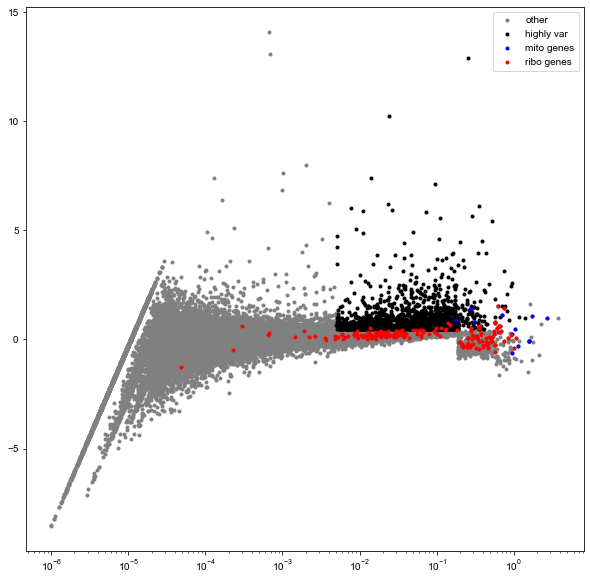

In [7]:
min_mean = 0.005# 0.01 #0.0005
max_mean = 1.5
min_disp = 0.7

sc.pp.highly_variable_genes(adata_merged)#,min_mean = min_mean,min_disp=min_disp,max_mean=max_mean)

top_ = sorted(adata_merged.var['dispersions_norm'][(adata_merged.var['means'] >= min_mean) & 
                                                      (adata_merged.var['means'] < max_mean)],
                  reverse=True)[2000]
adata_merged.var['highly_variable'] = (adata_merged.var['dispersions_norm'] >= top_) \
& (adata_merged.var['means'] >= min_mean) & (adata_merged.var['means'] < max_mean)
adata_merged.var[adata_merged.var['highly_variable'] == True].sort_values(['means'],ascending=False)[0:50]
adata_merged.var[adata_merged.var['highly_variable'] == True].sort_values(['means'],ascending=True)[0:50]

plt.figure(figsize=(10,10))
plt.plot(adata_merged.var[adata_merged.var['highly_variable'] == False]['means'],adata_merged.var[adata_merged.var['highly_variable'] == False]['dispersions_norm'],'.',color='gray',label='other')
plt.plot(adata_merged.var[adata_merged.var['highly_variable'] == True]['means'],adata_merged.var[adata_merged.var['highly_variable'] == True]['dispersions_norm'],'.',color='black',label='highly var')
plt.plot(adata_merged.var.loc[mito_genes]['means'],adata_merged.var.loc[mito_genes]['dispersions_norm'],'.',color='blue',label='mito genes')
plt.plot(adata_merged.var.loc[rb_genes]['means'],adata_merged.var.loc[rb_genes]['dispersions_norm'],'.',color='red',label='ribo genes')
plt.xscale('log')
plt.legend()
plt.savefig('figures/'+line_+'/hvg.png')
plt.show()

In [8]:
adata_merged_backup = copy.deepcopy(adata_merged)

In [9]:
'''
adata_merged = adata_merged[:,adata_merged.var[adata_merged.var['highly_variable'] == True].index]
adata_zip8k8 = adata_merged[adata_merged.obs['line']=='zip8k8']
adata_zip13k5 = adata_merged[adata_merged.obs['line']=='zip13k5']
adata_FOK1 = adata_merged[adata_merged.obs['line']=='FOK1']
adata_KUCG2 = adata_merged[adata_merged.obs['line']=='KUCG2']

import scanorama
# List of datasets:
adatas = [adata_zip13k5,adata_zip8k8,adata_FOK1,adata_KUCG2]
# Integration and batch correction.
corrected = scanorama.correct_scanpy(adatas, return_dimred=True)
# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in corrected]
# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)
# add to the AnnData object
adata_merged.obsm["X_scanorama"] = all_s
# tsne and umap
sc.pp.neighbors(adata_merged, n_neighbors=50, n_pcs =50, use_rep = "X_scanorama")
sc.tl.umap(adata_merged,min_dist=0.1)
'''

'\nadata_merged = adata_merged[:,adata_merged.var[adata_merged.var[\'highly_variable\'] == True].index]\nadata_zip8k8 = adata_merged[adata_merged.obs[\'line\']==\'zip8k8\']\nadata_zip13k5 = adata_merged[adata_merged.obs[\'line\']==\'zip13k5\']\nadata_FOK1 = adata_merged[adata_merged.obs[\'line\']==\'FOK1\']\nadata_KUCG2 = adata_merged[adata_merged.obs[\'line\']==\'KUCG2\']\n\nimport scanorama\n# List of datasets:\nadatas = [adata_zip13k5,adata_zip8k8,adata_FOK1,adata_KUCG2]\n# Integration and batch correction.\ncorrected = scanorama.correct_scanpy(adatas, return_dimred=True)\n# Get all the integrated matrices.\nscanorama_int = [ad.obsm[\'X_scanorama\'] for ad in corrected]\n# make into one matrix.\nall_s = np.concatenate(scanorama_int)\nprint(all_s.shape)\n# add to the AnnData object\nadata_merged.obsm["X_scanorama"] = all_s\n# tsne and umap\nsc.pp.neighbors(adata_merged, n_neighbors=50, n_pcs =50, use_rep = "X_scanorama")\nsc.tl.umap(adata_merged,min_dist=0.1)\n'

In [10]:
adata_merged.obs['line'] = adata_merged.obs['line'].astype('category')

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


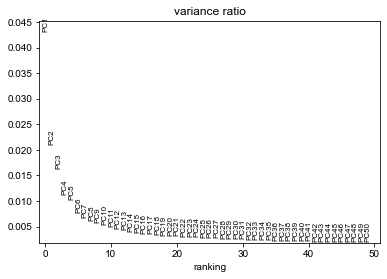

In [11]:
sc.tl.pca(adata_merged, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_merged, log=False, n_pcs=50, save=True)

sc.pp.neighbors(adata_merged,n_neighbors=14)#50)#20)##6)12)
sc.tl.umap(adata_merged,min_dist=0.1)

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


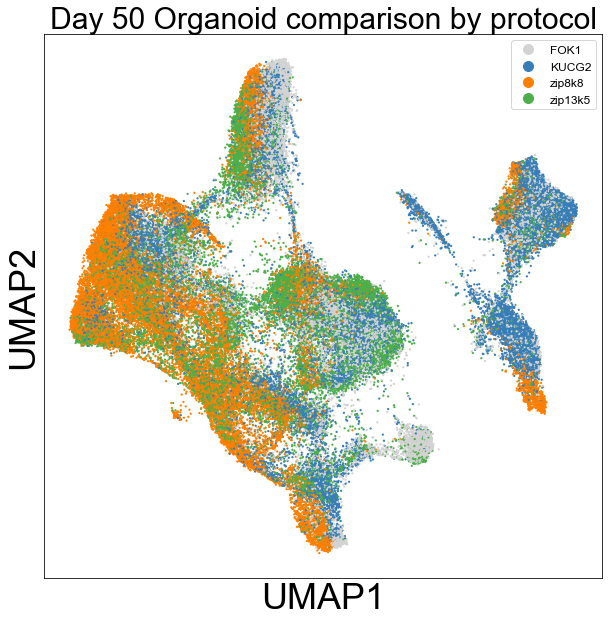

In [12]:
## overall fig
fig = plt.figure(figsize=(10,10))
clrs = sns.color_palette('Set1', n_colors=10)  # a list of RGB tuples
color_d = {'FOK1':'lightgray','KUCG2':clrs[1],'zip8k8':clrs[4],'zip13k5':clrs[2]}

xs = adata_merged.obsm['X_umap'][:,0]
ys = adata_merged.obsm['X_umap'][:,1]
colors = [color_d[line] for line in adata_merged.obs['line']]
idx_list = list(range(len(xs)))
random.shuffle(idx_list)

plt.scatter(x=[xs[i] for i in idx_list],y=[ys[i] for i in idx_list],color=[colors[i] for i in idx_list],s=5,alpha=1,ec=None)
xlim = plt.xlim()
ylim = plt.ylim()
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
for line in ['FOK1','KUCG2','zip8k8','zip13k5']:
    plt.plot(-10000,-10000,'o',markersize=10,label=line,color=color_d[line])

plt.xticks([])
plt.yticks([])
plt.xlabel('UMAP1',fontsize=36)
plt.ylabel('UMAP2',fontsize=36)
plt.title('Day 50 Organoid comparison by protocol',fontsize=30)
plt.legend(fontsize=12)
plt.savefig('figures/'+line_+'/merged_umap.line.png',dpi=250)
plt.savefig('figures/'+line_+'/merged_umap.line.pdf',dpi=250)

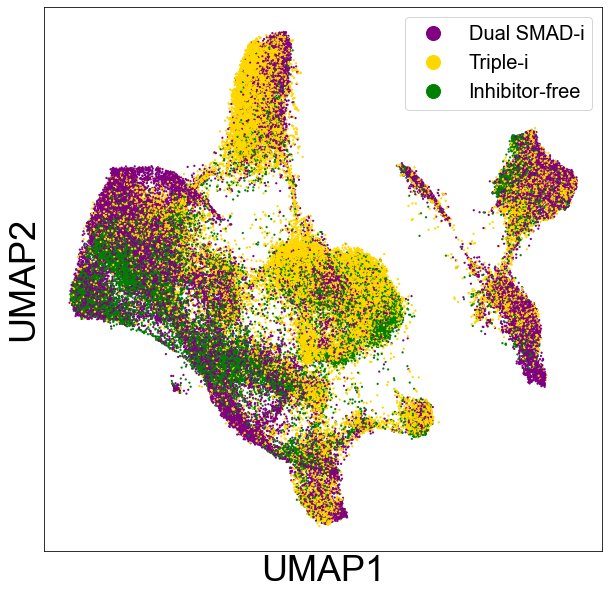

In [13]:
## overall fig
fig = plt.figure(figsize=(10,10))
color_d = {'sbnx':'gold','sbn':'purple','nt':'green'}
tx_dict = {'sbnx':'Triple-i','sbn':'Dual SMAD-i','nt':'Inhibitor-free'}

xs = adata_merged.obsm['X_umap'][:,0]
ys = adata_merged.obsm['X_umap'][:,1]
colors = [color_d[line] for line in adata_merged.obs['tx']]
idx_list = list(range(len(xs)))
random.shuffle(idx_list)

plt.scatter(x=[xs[i] for i in idx_list],y=[ys[i] for i in idx_list],color=[colors[i] for i in idx_list],s=5,alpha=1,ec=None)
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
for tx in ['sbn','sbnx','nt']:
    plt.plot(-10000,-10000,'o',markersize=14,label=tx_dict[tx],color=color_d[tx])

plt.xticks([])
plt.yticks([])
plt.xlabel('UMAP1',fontsize=36)
plt.ylabel('UMAP2',fontsize=36)
#plt.title('Day 28 Organoid comparison by protocol',fontsize=44)
plt.legend(fontsize=20)
#plt.savefig('/project/elkabetz_lab/Daniel/Manuscript/Figures/kriegstein_merge/merged_umap.pdf')
plt.savefig('figures/'+line_+'/merged_umap.png',dpi=250)
plt.savefig('figures/'+line_+'/merged_umap.pdf',dpi=250)

In [14]:
sc.tl.louvain(adata_merged,resolution=4)#3.4)

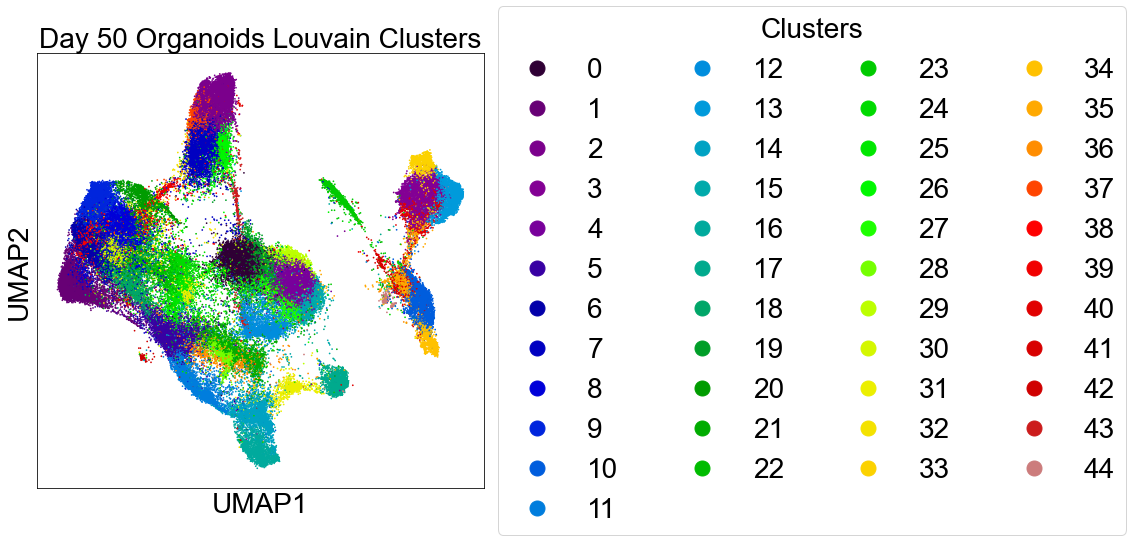

In [56]:
plt.figure(figsize=(10,8))
ax = plt.subplot(111)
clusts = sorted([int(x) for x in set(adata_merged.obs['louvain'])])
clrs = sns.color_palette('nipy_spectral', n_colors=len(clusts))  # a list of RGB tuples
final_colors = []
for j,cell in enumerate(adata_merged.obs['louvain']): 
    final_colors.append(clrs[int(cell)])

plt.scatter(adata_merged.obsm['X_umap'][:,0],adata_merged.obsm['X_umap'][:,1],c=final_colors,s=3,ec=None)
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
for j,cell_type in enumerate(clusts):
    plt.plot(-10000,-10000,'.',color=clrs[j],label=cell_type,markersize=30)

plt.title('Day 50 Organoids Louvain Clusters', fontsize=28)
plt.xlabel('UMAP1',fontsize=28)
plt.ylabel('UMAP2',fontsize=28)
plt.xticks([])
plt.yticks([])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=28,title='Clusters',title_fontsize=28,ncol=4)
plt.savefig('figures/'+line_+'/UMAP.louvain.png',dpi=500,bbox_inches='tight')

... storing 'tx' as categorical
/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


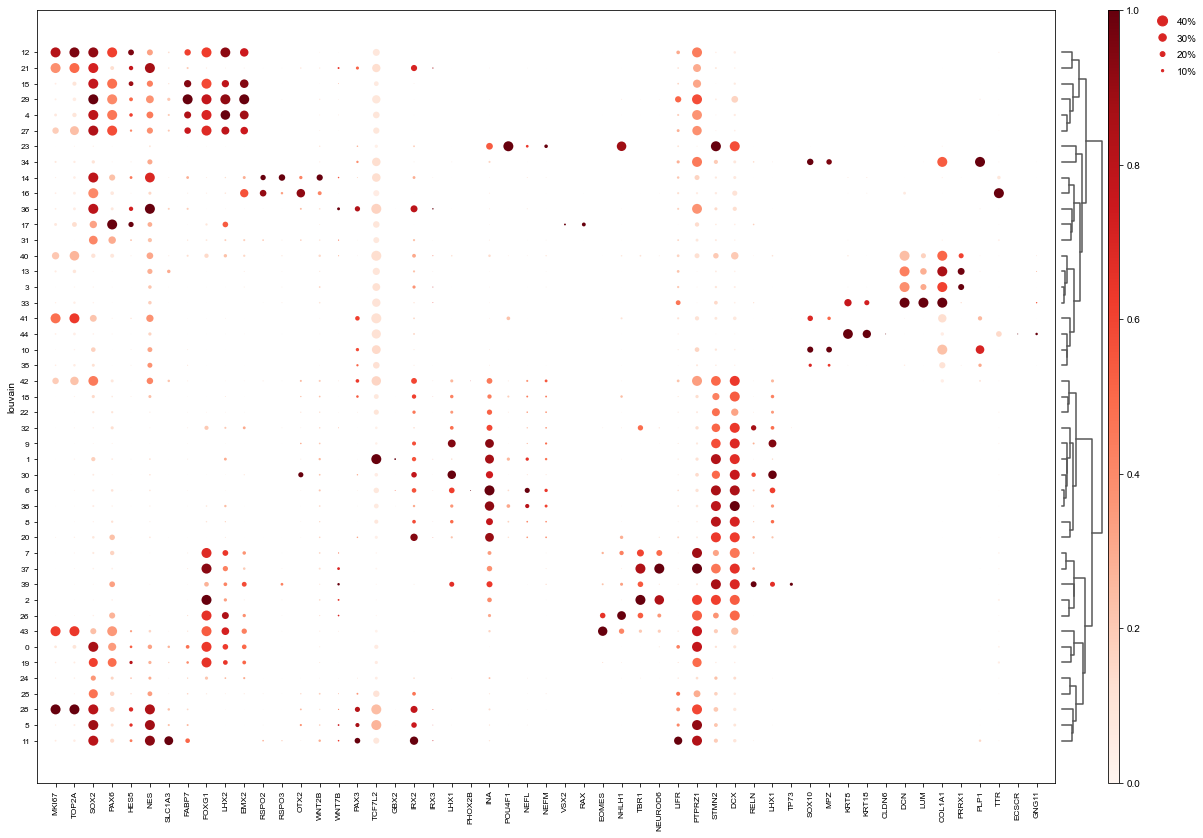

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[18.549999999999997, 0.8, 0.2, 0.5, 0.25])

In [16]:
sc.tl.dendrogram(adata_merged,groupby='louvain')
sc.pl.dotplot(adata_merged,var_names=['MKI67','TOP2A','SOX2','PAX6','HES5','NES','SLC1A3','FABP7','FOXG1','LHX2','EMX2',
    'RSPO2','RSPO3','OTX2','WNT2B','WNT7B','PAX3','TCF7L2','GBX2','IRX2','IRX3','LHX1',
    'PHOX2B','INA','POU4F1','NEFL','NEFM','VSX2','RAX',
    'EOMES','NHLH1','TBR1','NEUROD6','LIFR','PTPRZ1','STMN2','DCX','RELN','LHX1','TP73',
    'SOX10','MPZ','KRT8','KRT18','CLDN6','DCN','LUM','COL1A1','PRRX1','PLP1','TTR','ECSCR','GNG11'],
    groupby='louvain',dendrogram=True,dot_min=0.01,dot_max=0.4,save=line_+'dotplot.pdf',standard_scale='var')#,dot_min=0.01,dot_max=0.5

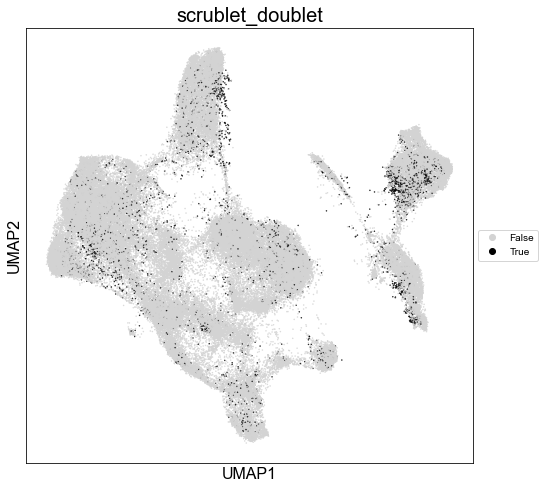

In [17]:
plt.figure(figsize=(10,8))
ax = plt.subplot(111)
clusts = sorted([x for x in set(adata_merged.obs['scrublet_doublet'])])
clrs = ['lightgray','black']
final_colors = []
for j,cell in enumerate(adata_merged.obs['scrublet_doublet']): 
    final_colors.append(clrs[int(cell)])

plt.scatter(adata_merged.obsm['X_umap'][:,0],adata_merged.obsm['X_umap'][:,1],c=final_colors,s=0.2)
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
for j,cell_type in enumerate(clusts):
    plt.plot(-10000,-10000,'.',color=clrs[j],label=cell_type,markersize=12)

plt.title('scrublet_doublet', fontsize=20)
plt.xlabel('UMAP1',fontsize=16)
plt.ylabel('UMAP2',fontsize=16)
plt.xticks([])
plt.yticks([])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=10)
plt.savefig('figures/'+line_+'/UMAP.scrublet.png',dpi=500)

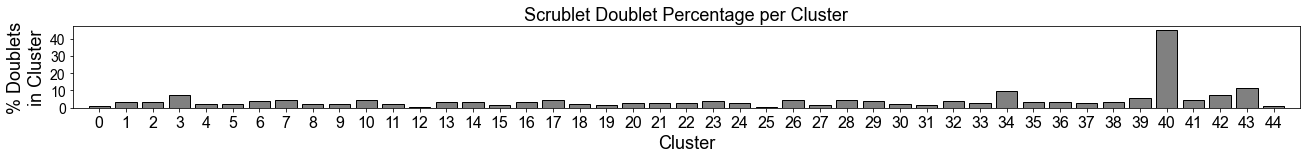

In [77]:
plt.figure(figsize=(22,1.5))
for j,clust in enumerate(sorted([int(x) for x in set(adata_merged.obs['louvain'])])):
    plt.bar(j,len(adata_merged.obs[(adata_merged.obs['louvain']==str(clust)) & (adata_merged.obs['scrublet_doublet']==True)])/sum(adata_merged.obs['louvain']==str(clust)),color='gray',edgecolor='black')

plt.title('Scrublet Doublet Percentage per Cluster',fontsize=18)
plt.xticks(range(len(set(adata_merged.obs['louvain']))),
           sorted([int(x) for x in set(adata_merged.obs['louvain'])]),fontsize=16)
plt.yticks([0,0.1,0.2,0.3,0.4],[0,10,20,30,40],fontsize=14)
plt.xlim(-1,len(set(adata_merged.obs['louvain'])))
#plt.axhline(0.1,color='black',linestyle='--',zorder=-1)
plt.xlabel('Cluster',fontsize=18)
plt.ylabel('% Doublets\nin Cluster',fontsize=18)
plt.savefig('figures/'+line_+'/doublet_percentages.png',dpi=500,bbox_inches='tight')

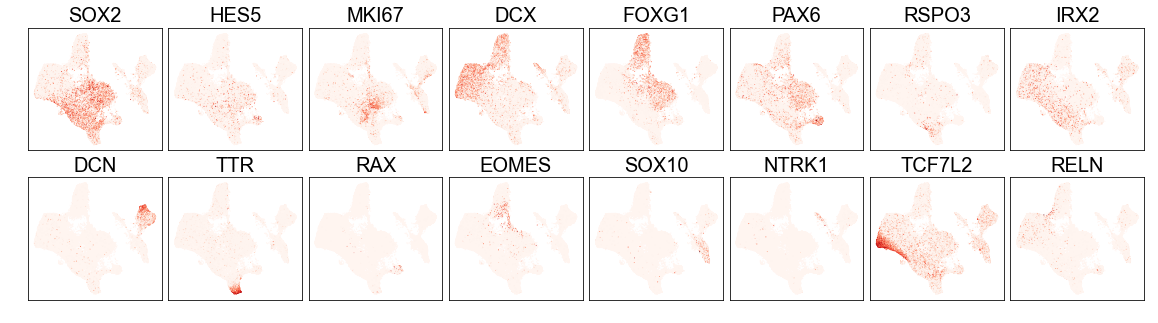

In [70]:
fig=plt.figure(figsize=(20,5))
for k,gene in enumerate(['SOX2','HES5','MKI67','DCX','FOXG1','PAX6','RSPO3','IRX2','DCN','TTR','RAX','EOMES','SOX10','NTRK1','TCF7L2','RELN']):
    ax = plt.subplot(2,8,k+1)
    vmin = 0
    vmax = max(adata_merged.X[:,list(adata_merged.var.index).index(gene)])
    colormap = cm.Reds
    normalize = Normalize(vmin=vmin, vmax=vmax)
    xs = adata_merged.obsm['X_umap'][:,0]
    ys = adata_merged.obsm['X_umap'][:,1]
    plt.scatter(xs,ys,c=adata_merged.X[:,list(adata_merged.var.index).index(gene)],
                cmap=colormap,norm=normalize,s=1,ec=None)
    plt.xticks([])
    plt.yticks([])
    #plt.xlabel('UMAP1',fontsize=16)
    #plt.ylabel('UMAP2',fontsize=16)
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.title(gene,fontsize=20)
    '''
    cbar = plt.colorbar()#colormap)
    cbar.set_ticks([0,vmax],[0,vmax])
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_title('Expr.',fontsize=18)
    '''
    
plt.subplots_adjust(wspace=0.05,hspace=0.22)
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.savefig('figures/'+line_+'/gene_panel_v2.png',dpi=500)

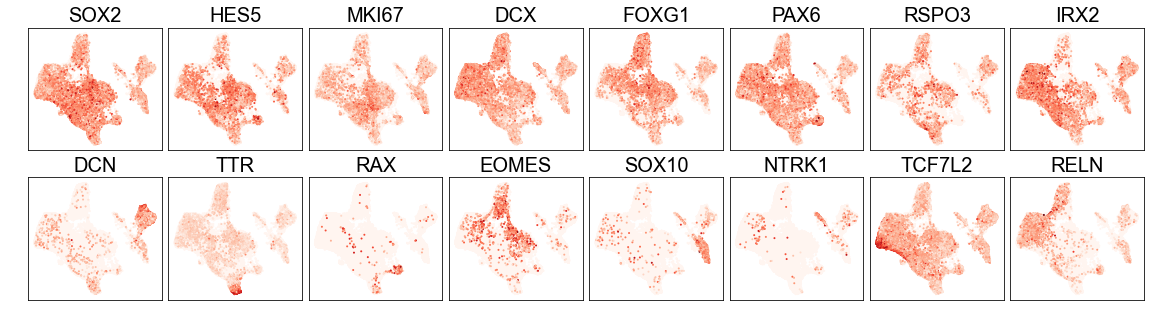

In [68]:
fig=plt.figure(figsize=(20,5))
for k,gene in enumerate(['SOX2','HES5','MKI67','DCX','FOXG1','PAX6','RSPO3','IRX2','DCN','TTR','RAX','EOMES','SOX10','NTRK1','TCF7L2','RELN']):
    ax = plt.subplot(2,8,k+1)
    vmin = 0
    vmax = max(adata_merged.X[:,list(adata_merged.var.index).index(gene)])
    colormap = cm.Reds
    normalize = Normalize(vmin=vmin, vmax=vmax)
    idx0 = np.where(adata_merged.X[:,list(adata_merged.var.index).index(gene)]==0)
    xs0 = adata_merged.obsm['X_umap'][idx0,0]
    ys0 = adata_merged.obsm['X_umap'][idx0,1]
    idx_pos = np.where(adata_merged.X[:,list(adata_merged.var.index).index(gene)]>0)
    xs_pos = adata_merged.obsm['X_umap'][idx_pos,0]
    ys_pos = adata_merged.obsm['X_umap'][idx_pos,1]
    plt.scatter(xs0,ys0,c=adata_merged.X[idx0,list(adata_merged.var.index).index(gene)],
                cmap=colormap,norm=normalize,s=4,ec=None)
    plt.scatter(xs_pos,ys_pos,c=adata_merged.X[idx_pos,list(adata_merged.var.index).index(gene)],
                cmap=colormap,norm=normalize,s=4,ec=None)
    plt.xticks([])
    plt.yticks([])
    #plt.xlabel('UMAP1',fontsize=16)
    #plt.ylabel('UMAP2',fontsize=16)
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.title(gene,fontsize=20)
    '''
    cbar = plt.colorbar()#colormap)
    cbar.set_ticks([0,vmax],[0,vmax])
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_title('Expr.',fontsize=18)
    '''
    
plt.subplots_adjust(wspace=0.05,hspace=0.22)
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.savefig('figures/'+line_+'/gene_panel_v3.png',dpi=500)

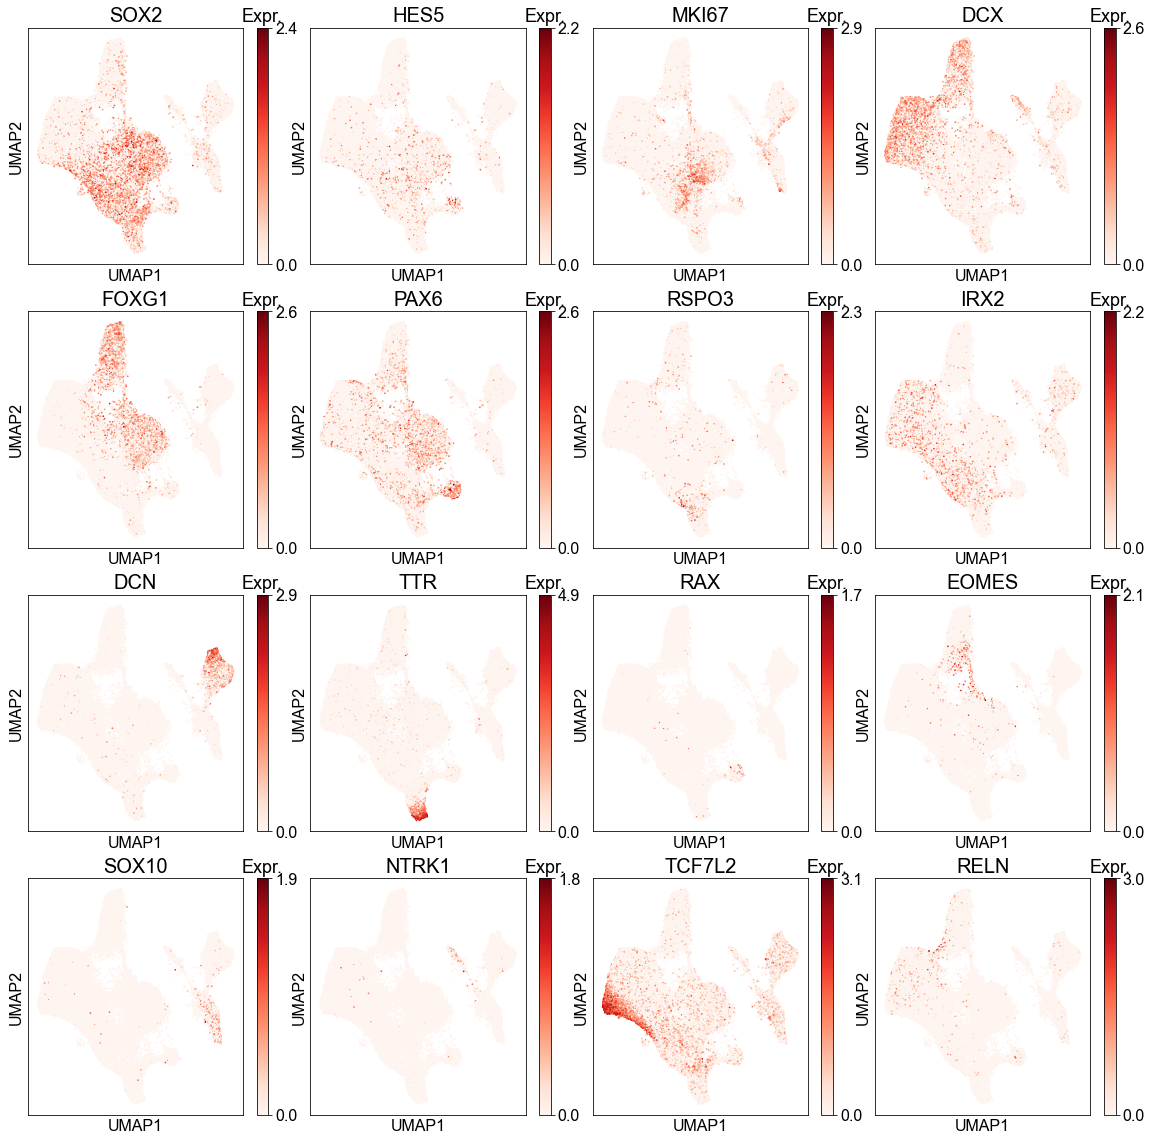

In [19]:
fig=plt.figure(figsize=(20,20))
for k,gene in enumerate(['SOX2','HES5','MKI67','DCX','FOXG1','PAX6','RSPO3','IRX2','DCN','TTR','RAX','EOMES','SOX10','NTRK1','TCF7L2','RELN']):
    ax = plt.subplot(4,4,k+1)
    vmin = 0
    vmax = max(adata_merged.X[:,list(adata_merged.var.index).index(gene)])
    colormap = cm.Reds
    normalize = Normalize(vmin=vmin, vmax=vmax)
    xs = adata_merged.obsm['X_umap'][:,0]
    ys = adata_merged.obsm['X_umap'][:,1]
    plt.scatter(xs,ys,c=adata_merged.X[:,list(adata_merged.var.index).index(gene)],cmap=colormap,norm=normalize,s=3,ec=None)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('UMAP1',fontsize=16)
    plt.ylabel('UMAP2',fontsize=16)
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.title(gene,fontsize=20)
    cbar = plt.colorbar()#colormap)
    cbar.set_ticks([0,vmax],[0,vmax])
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_title('Expr.',fontsize=18)
    
plt.subplots_adjust(wspace=0.05,hspace=0.2)
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.savefig('figures/'+line_+'/gene_panel.png',dpi=500)

KeyboardInterrupt: 

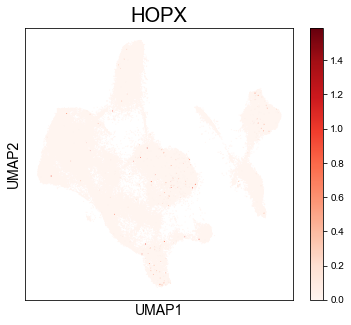

In [21]:
for k,gene in enumerate(['HOPX','RELN','TP73','CREB5','MKI67','TOP2A','SOX2','PAX6','HES5','EOMES','DCX','FOXG1','IRX2','IRX3','RSPO2','RSPO3','LMX1A',
    'EMX2','LHX2','EMX1','SFRP1','DCN','LUM','S100B','MPZ','SOX10','PAX3','DMBX1','DBX1','PHOX2B','ATOH1','PTF1A','BARHL1',
    'VSX2','RAX','DLX1','DLX2','DLX5','DLX6','TTR','COL1A1','COL3A1','POU5F1','UTF1','NEUROD6','ALX1',
    'PRRX1','TGFBI','GNG11','TIE1','ECSCR','KRT8','KRT18','HES6','NHLH1','NHLH2','LZTS1','DLL1',
    'TPBG','WLS','ZIC4','CCND1','FABP7','NFIA','NFIB','TBR1','NEFL','NEFM',
    'LIFR','STMN2','PTPRZ1','CNTNAP2','RTN1','SLC1A3','DACH1','PALLD','FZD8','TBR1','TCF7L2','POU3F2','POU3F1','POU3F4',
    'TIAM2','MEF2C','PLXNA4','ARX','ASCL1','DPYSL3','CALRN','CALB1','CALB2']):
    if gene not in adata_merged.var.index: continue
    ax = plt.figure(figsize=(6,5))
    vmin = 0
    vmax = max(adata_merged.X[:,list(adata_merged.var.index).index(gene)])
    colormap = cm.Reds
    normalize = Normalize(vmin=vmin, vmax=vmax)
    xs = adata_merged.obsm['X_umap'][:,0]
    ys = adata_merged.obsm['X_umap'][:,1]
    plt.scatter(xs,ys,c=adata_merged.X[:,list(adata_merged.var.index).index(gene)],cmap=colormap,norm=normalize,s=1,ec=None)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('UMAP1',fontsize=14)
    plt.ylabel('UMAP2',fontsize=14)
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.title(gene,fontsize=20)
    cbar = plt.colorbar()#colormap)
    plt.savefig('figures/'+line_+'/genes/'+gene+'.png',dpi=500)
    plt.savefig('figures/'+line_+'/genes/'+gene+'.pdf')

In [22]:
line.upper()

'ZIP13K5'

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


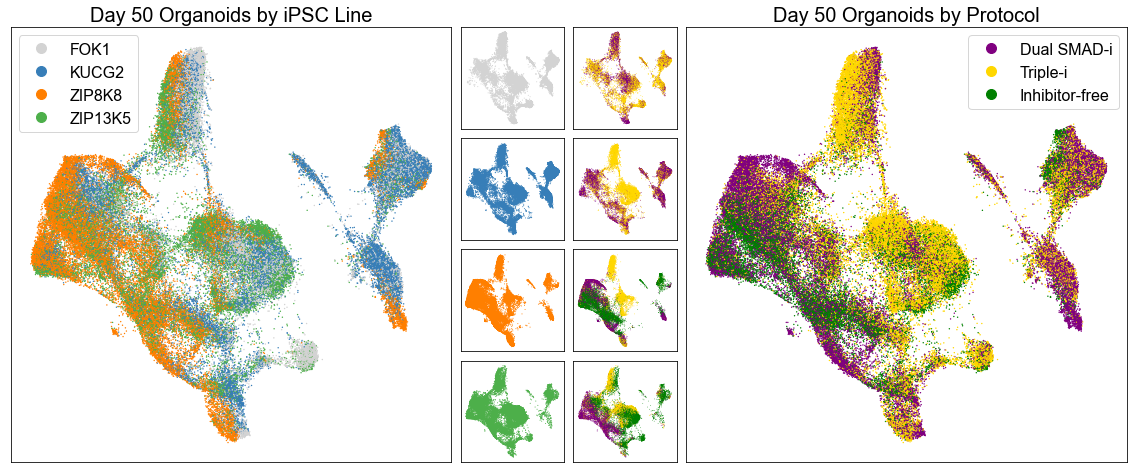

In [23]:
## overall fig with gridspec
fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(8,20,wspace=0.2, hspace=0.2)
ax = plt.subplot(gs[:,:8])
clrs = sns.color_palette('Set1', n_colors=10)  # a list of RGB tuples
color_d = {'FOK1':'lightgray','KUCG2':clrs[1],'zip8k8':clrs[4],'zip13k5':clrs[2]}

xs = []
ys = []
colors = []
for j,line in enumerate(['FOK1','KUCG2','zip8k8','zip13k5']):
    xs.extend([x[0] for x in adata_merged.obsm['X_umap'][adata_merged.obs[adata_merged.obs['line']==line]['Index']]])
    ys.extend([x[1] for x in adata_merged.obsm['X_umap'][adata_merged.obs[adata_merged.obs['line']==line]['Index']]])
    colors.extend([color_d[line] for x in range(len(adata_merged.obs[adata_merged.obs['line']==line]))])

idx = list(range(len(xs)))
random.shuffle(idx)
plt.scatter(x=[xs[i] for i in idx],y=[ys[i] for i in idx],color=[colors[i] for i in idx],s=2,alpha=1,ec=None)
xlim = plt.xlim()
ylim = plt.ylim()
plt.xlim(xlim)
plt.ylim(ylim)
for line in ['FOK1','KUCG2','zip8k8','zip13k5']:
    plt.plot(-10000,-10000,'o',markersize=10,label=line.upper(),color=color_d[line])

plt.xticks([])
plt.yticks([])
plt.legend(fontsize=16)
plt.title('Day 50 Organoids by iPSC Line',fontsize=20)

for j,line in enumerate(['FOK1','KUCG2','zip8k8','zip13k5']):
    ax = plt.subplot(gs[2*j:2*j+2,8:10])
    plt.scatter(x=[x[0] for x in adata_merged.obsm['X_umap'][adata_merged.obs[adata_merged.obs['line']==line]['Index']]],
        y=[x[1] for x in adata_merged.obsm['X_umap'][adata_merged.obs[adata_merged.obs['line']==line]['Index']]],color=color_d[line],
        s=1,alpha=1,ec=None)
    plt.xlim(xlim)
    plt.ylim(ylim)
    #plt.title(line,fontsize=10)
    plt.xticks([])
    plt.yticks([])

color_d = {'sbnx':'gold','sbn':'purple','nt':'green'}
tx_dict = {'sbnx':'Triple-i','sbn':'Dual SMAD-i','nt':'Inhibitor-free'}

for j,line in enumerate(['FOK1','KUCG2','zip8k8','zip13k5']):
    ax = plt.subplot(gs[2*j:2*j+2,10:12])
    xs = []
    ys = []
    colors = []
    for tx in ['sbn','sbnx','nt']:
        xs.extend([x[0] for x in adata_merged.obsm['X_umap'][adata_merged.obs[(adata_merged.obs['tx']==tx) & (adata_merged.obs['line']==line)]['Index']]])
        ys.extend([x[1] for x in adata_merged.obsm['X_umap'][adata_merged.obs[(adata_merged.obs['tx']==tx) & (adata_merged.obs['line']==line)]['Index']]])
        colors.extend([color_d[tx] for x in range(len(adata_merged.obs[(adata_merged.obs['tx']==tx) & (adata_merged.obs['line']==line)]))])
    #randomly sort xs, ys, colors
    idx = list(range(len(xs)))
    random.shuffle(idx)
    plt.scatter(x=[xs[i] for i in idx],y=[ys[i] for i in idx],color=[colors[i] for i in idx],s=0.5,alpha=1,ec=None)
    plt.xlim(xlim)
    plt.ylim(ylim)
    #plt.title(line,fontsize=10)
    plt.xticks([])
    plt.yticks([])

ax = plt.subplot(gs[:,12:])
clrs = sns.color_palette('Set1', n_colors=10)  # a list of RGB tuples
color_d = {'sbnx':'gold','sbn':'purple','nt':'green'}
tx_dict = {'sbnx':'Triple-i','sbn':'Dual SMAD-i','nt':'Inhibitor-free'}

xs = []
ys = []
colors = []
for j,tx in enumerate(['sbn','sbnx','nt']):
    xs.extend([x[0] for x in adata_merged.obsm['X_umap'][adata_merged.obs[adata_merged.obs['tx']==tx]['Index']]])
    ys.extend([x[1] for x in adata_merged.obsm['X_umap'][adata_merged.obs[adata_merged.obs['tx']==tx]['Index']]])
    colors.extend([color_d[tx] for x in range(len(adata_merged.obs[adata_merged.obs['tx']==tx]))])

idx = list(range(len(xs)))
random.shuffle(idx)
plt.scatter(x=[xs[i] for i in idx],y=[ys[i] for i in idx],color=[colors[i] for i in idx],s=2,alpha=1,ec=None)
plt.xlim(xlim)
plt.ylim(ylim)
for tx in ['sbn','sbnx','nt']:
    plt.plot(-10000,-10000,'o',markersize=10,label=tx_dict[tx],color=color_d[tx])

plt.legend(fontsize=16)
plt.xticks([])
plt.yticks([])
plt.title('Day 50 Organoids by Protocol',fontsize=20)

#fig.supxlabel('UMAP1',fontsize=20)
#fig.supylabel('UMAP2',fontsize=20)

plt.savefig('figures/'+line_+'/merged_umap.line.with_gridspec.png',dpi=1000)
plt.savefig('figures/'+line_+'/merged_umap.line.with_gridspec.pdf')
plt.savefig('figures/'+line_+'/merged_umap.line.with_gridspec.svg')

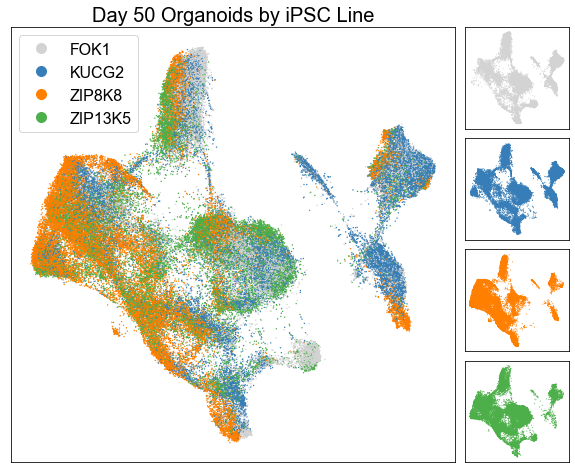

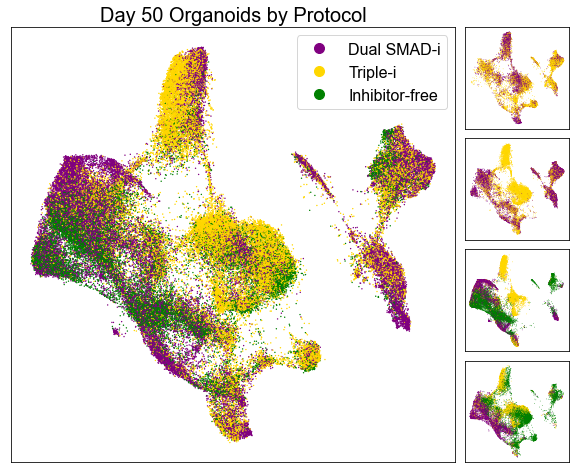

In [25]:
## overall fig with gridspec
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(8,10,wspace=0.2, hspace=0.2)
ax = plt.subplot(gs[:,:8])
clrs = sns.color_palette('Set1', n_colors=10)  # a list of RGB tuples
color_d = {'FOK1':'lightgray','KUCG2':clrs[1],'zip8k8':clrs[4],'zip13k5':clrs[2]}

xs = []
ys = []
colors = []
for j,line in enumerate(['FOK1','KUCG2','zip8k8','zip13k5']):
    xs.extend([x[0] for x in adata_merged.obsm['X_umap'][adata_merged.obs[adata_merged.obs['line']==line]['Index']]])
    ys.extend([x[1] for x in adata_merged.obsm['X_umap'][adata_merged.obs[adata_merged.obs['line']==line]['Index']]])
    colors.extend([color_d[line] for x in range(len(adata_merged.obs[adata_merged.obs['line']==line]))])

idx = list(range(len(xs)))
random.shuffle(idx)
plt.scatter(x=[xs[i] for i in idx],y=[ys[i] for i in idx],color=[colors[i] for i in idx],s=2,alpha=1,ec=None)
xlim = plt.xlim()
ylim = plt.ylim()
plt.xlim(xlim)
plt.ylim(ylim)
for line in ['FOK1','KUCG2','zip8k8','zip13k5']:
    plt.plot(-10000,-10000,'o',markersize=10,label=line.upper(),color=color_d[line])

plt.xticks([])
plt.yticks([])
plt.legend(fontsize=16)
plt.title('Day 50 Organoids by iPSC Line',fontsize=20)

for j,line in enumerate(['FOK1','KUCG2','zip8k8','zip13k5']):
    ax = plt.subplot(gs[2*j:2*j+2,8:10])
    plt.scatter(x=[x[0] for x in adata_merged.obsm['X_umap'][adata_merged.obs[adata_merged.obs['line']==line]['Index']]],
        y=[x[1] for x in adata_merged.obsm['X_umap'][adata_merged.obs[adata_merged.obs['line']==line]['Index']]],color=color_d[line],
        s=1,alpha=1,ec=None)
    plt.xlim(xlim)
    plt.ylim(ylim)
    #plt.title(line,fontsize=10)
    plt.xticks([])
    plt.yticks([])

plt.savefig('figures/'+line_+'/merged_umap.line.with_gridspec.comp1.png',dpi=1000)
plt.savefig('figures/'+line_+'/merged_umap.line.with_gridspec.comp1.pdf')
plt.savefig('figures/'+line_+'/merged_umap.line.with_gridspec.comp1.svg')

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(8,10,wspace=0.2, hspace=0.2)

color_d = {'sbnx':'gold','sbn':'purple','nt':'green'}
tx_dict = {'sbnx':'Triple-i','sbn':'Dual SMAD-i','nt':'Inhibitor-free'}

for j,line in enumerate(['FOK1','KUCG2','zip8k8','zip13k5']):
    ax = plt.subplot(gs[2*j:2*j+2,8:10])
    xs = []
    ys = []
    colors = []
    for tx in ['sbn','sbnx','nt']:
        xs.extend([x[0] for x in adata_merged.obsm['X_umap'][adata_merged.obs[(adata_merged.obs['tx']==tx) & (adata_merged.obs['line']==line)]['Index']]])
        ys.extend([x[1] for x in adata_merged.obsm['X_umap'][adata_merged.obs[(adata_merged.obs['tx']==tx) & (adata_merged.obs['line']==line)]['Index']]])
        colors.extend([color_d[tx] for x in range(len(adata_merged.obs[(adata_merged.obs['tx']==tx) & (adata_merged.obs['line']==line)]))])
    #randomly sort xs, ys, colors
    idx = list(range(len(xs)))
    random.shuffle(idx)
    plt.scatter(x=[xs[i] for i in idx],y=[ys[i] for i in idx],color=[colors[i] for i in idx],s=0.5,alpha=1,ec=None)
    plt.xlim(xlim)
    plt.ylim(ylim)
    #plt.title(line,fontsize=10)
    plt.xticks([])
    plt.yticks([])

ax = plt.subplot(gs[:,:8])
clrs = sns.color_palette('Set1', n_colors=10)  # a list of RGB tuples
color_d = {'sbnx':'gold','sbn':'purple','nt':'green'}
tx_dict = {'sbnx':'Triple-i','sbn':'Dual SMAD-i','nt':'Inhibitor-free'}

xs = []
ys = []
colors = []
for j,tx in enumerate(['sbn','sbnx','nt']):
    xs.extend([x[0] for x in adata_merged.obsm['X_umap'][adata_merged.obs[adata_merged.obs['tx']==tx]['Index']]])
    ys.extend([x[1] for x in adata_merged.obsm['X_umap'][adata_merged.obs[adata_merged.obs['tx']==tx]['Index']]])
    colors.extend([color_d[tx] for x in range(len(adata_merged.obs[adata_merged.obs['tx']==tx]))])

idx = list(range(len(xs)))
random.shuffle(idx)
plt.scatter(x=[xs[i] for i in idx],y=[ys[i] for i in idx],color=[colors[i] for i in idx],s=2,alpha=1,ec=None)
plt.xlim(xlim)
plt.ylim(ylim)
for tx in ['sbn','sbnx','nt']:
    plt.plot(-10000,-10000,'o',markersize=10,label=tx_dict[tx],color=color_d[tx])

plt.legend(fontsize=16)
plt.xticks([])
plt.yticks([])
plt.title('Day 50 Organoids by Protocol',fontsize=20)

#fig.supxlabel('UMAP1',fontsize=20)
#fig.supylabel('UMAP2',fontsize=20)

plt.savefig('figures/'+line_+'/merged_umap.line.with_gridspec.comp2.png',dpi=1000)
plt.savefig('figures/'+line_+'/merged_umap.line.with_gridspec.comp2.pdf')
plt.savefig('figures/'+line_+'/merged_umap.line.with_gridspec.comp2.svg')

In [26]:
doublet_clusters = ['40']

cell_type_dict = {}
for clust in ['17']:
    cell_type_dict[clust] = 'Retinal NSC'

for clust in ['44']:
    cell_type_dict[clust] = 'Epithelial'

for clust in ['10','35','34']:
    cell_type_dict[clust] = 'Schwann Cells'

for clust in ['41']:
    cell_type_dict[clust] = 'Schwann Cells Dividing'    

for clust in ['14']:
    cell_type_dict[clust] = 'Hippocampal NSC'

for clust in ['11','5','25','36']:
    cell_type_dict[clust] = 'Posterior NSC'

for clust in ['28','21']:
    cell_type_dict[clust] = 'Posterior NSC Dividing'

for clust in ['33','3','13']:
    cell_type_dict[clust] = 'Mesoderm'

for clust in ['33','3','13']:
    cell_type_dict[clust] = 'Mesenchyme'

for clust in ['4','29','15','0','19']:
    cell_type_dict[clust] = 'Cortical NSC'

for clust in ['23']:
    cell_type_dict[clust] = 'Posterior CNS/PNS Neuron'

for clust in ['12','27']:
    cell_type_dict[clust] = 'Cortical NSC Dividing'

for clust in ['26','7']:
    cell_type_dict[clust] = 'Cortical IP'

for clust in ['43']:
    cell_type_dict[clust] = 'Cortical IP Dividing'

for clust in ['37','2']:
    cell_type_dict[clust] = 'Cortical Neuron'

for clust in ['39']:
    cell_type_dict[clust] = 'Cajal-Retzius Neuron'

for clust in ['16']:
    cell_type_dict[clust] = 'Choroid Plexus'

for clust in ['20','8','38','6','30','1','9','32','22','18','42']:
    cell_type_dict[clust] = 'Posterior Neuron'

for clust in ['31','24']:
    cell_type_dict[clust] = 'Unknown'

for clust in doublet_clusters:
    cell_type_dict[clust] = 'doublet'

adata_merged.obs['cell_type']=[cell_type_dict[x] for x in adata_merged.obs['louvain']]

cell_type_new = []
for doublet_status,cell_type in zip(adata_merged.obs['scrublet_doublet'],adata_merged.obs['cell_type']):
    if doublet_status == True:
        cell_type_new.append('doublet')
    else:
        cell_type_new.append(cell_type)

adata_merged.obs['cell_type']=cell_type_new

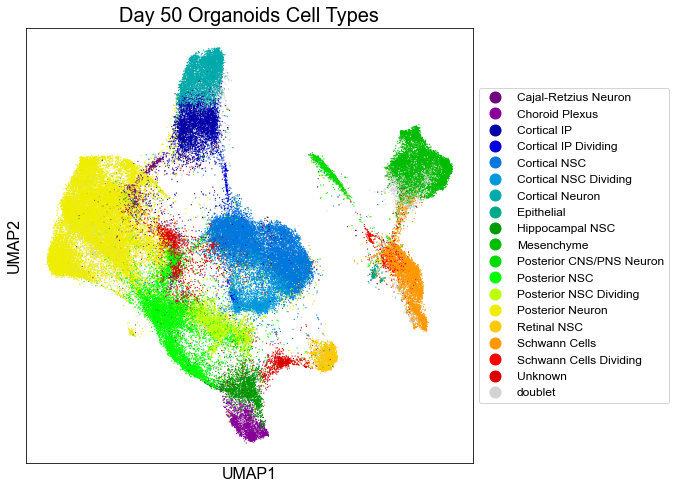

In [27]:
plt.figure(figsize=(10,8))
ax = plt.subplot(111)
clusts = sorted(set(adata_merged.obs['cell_type']))
clrs = sns.color_palette('nipy_spectral', n_colors=len(clusts))  # a list of RGB tuples
final_colors = []
clrs_dict = {}
for j,cell in enumerate(sorted(set(adata_merged.obs['cell_type']))):
    clrs_dict[cell] = clrs[j]

clrs_dict['doublet'] = 'lightgray'

for j,cell in enumerate(adata_merged.obs['cell_type']):
    final_colors.append(clrs_dict[cell])

plt.scatter(adata_merged.obsm['X_umap'][:,0],adata_merged.obsm['X_umap'][:,1],
    c=final_colors,s=1.5,ec=None)
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
for j,cell_type in enumerate(clusts):
    plt.plot(-10000,-10000,'.',color=clrs_dict[cell_type],label=cell_type,markersize=22)

plt.title('Day 50 Organoids Cell Types', fontsize=20)
plt.xlabel('UMAP1',fontsize=16)
plt.ylabel('UMAP2',fontsize=16)
plt.xticks([])
plt.yticks([])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)
plt.savefig('figures/'+line_+'/UMAP.cell_type.png',dpi=500)
plt.savefig('figures/'+line_+'/UMAP.cell_type.pdf')

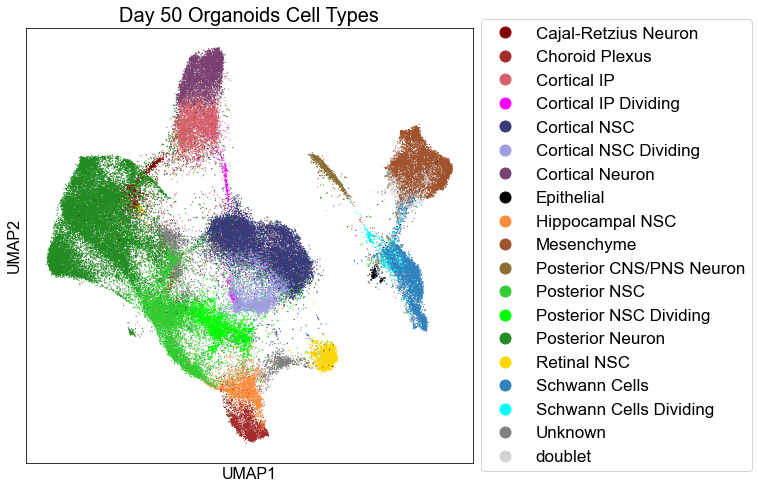

In [29]:
#normalize item number values to colormap
norm = matplotlib.colors.Normalize(vmin=0, vmax=20)

clrs_dict = {'Cortical NSC':cm.tab20b(norm(0)),
              'Cortical NSC Dividing':cm.tab20b(norm(3)),
              'Cortical IP':cm.tab20b(norm(14)),
              'Cortical IP Dividing':'magenta',
              'Cortical Neuron':cm.tab20b(norm(16)),
              'Subpallium Neuron':cm.tab20b(norm(5)),
              'Hippocampal Neuron':cm.tab20c(norm(4)),
              'Hippocampal IP':cm.tab20c(norm(6)),
              'Hippocampal NSC':cm.tab20c(norm(5)),
              'Hippocampal NSC Dividing':cm.tab20c(norm(7)),
              'Posterior Neuron':'forestgreen',#cm.tab20c(norm(0)),
              'Posterior NSC':'limegreen',#cm.tab20c(norm(8)),#cm.tab20c(norm(3)),
              'Posterior NSC Dividing':'lime',#'aqua',#cm.tab20c(norm(2)),
              'Schwann Cells':cm.tab20c(norm(0)),#cm.tab20c(norm(8)),
              'Schwann Cells Dividing':'aqua',#'lime',
              'Posterior CNS/PNS Neuron':cm.tab20b(norm(8)),
              'Mesoderm':'sienna',
              'Mesoderm Dividing':cm.tab20c(norm(17)),
              'Mesenchyme':'sienna',
              'Mesenchyme Dividing':cm.tab20c(norm(17)),
              'Epithelial':'black',
              'Endothelial':'peru',
              'Cajal-Retzius Neuron':'maroon',
              'Subpallium Neuron':'palegreen'}

clrs_dict['Unknown'] = 'gray'
clrs_dict['doublet'] = 'lightgray'
clrs_dict['Choroid Plexus'] = 'brown'
clrs_dict['Retinal NSC'] = 'gold'

plt.figure(figsize=(10,8))
ax = plt.subplot(111)
clusts = sorted(set(adata_merged.obs['cell_type']))
final_colors = []

for j,cell in enumerate(adata_merged.obs['cell_type']):
    final_colors.append(clrs_dict[cell])

plt.scatter(adata_merged.obsm['X_umap'][:,0],adata_merged.obsm['X_umap'][:,1],
    c=final_colors,s=1.5,ec=None)
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
for j,cell_type in enumerate(clusts):
    plt.plot(-10000,-10000,'.',color=clrs_dict[cell_type],label=cell_type,markersize=22)

plt.title('Day 50 Organoids Cell Types', fontsize=20)
plt.xlabel('UMAP1',fontsize=16)
plt.ylabel('UMAP2',fontsize=16)
plt.xticks([])
plt.yticks([])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=17)
plt.savefig('figures/'+line_+'/UMAP.cell_type.new_colors.png',dpi=500,bbox_inches='tight')
plt.savefig('figures/'+line_+'/UMAP.cell_type.new_colors.pdf')

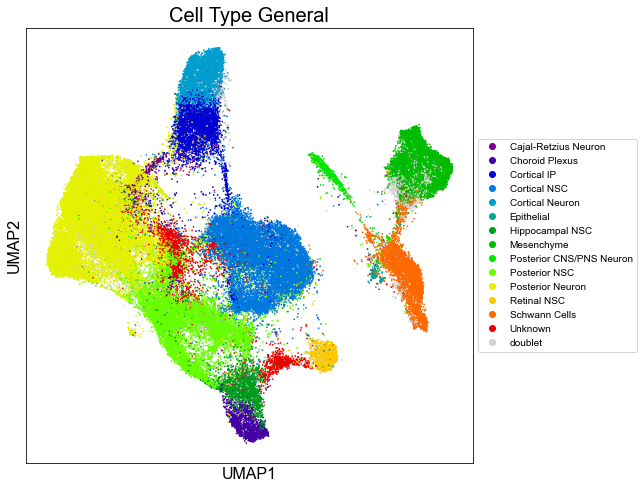

In [30]:
cell_type_general = []
for cell_type in adata_merged.obs['cell_type']:
    if 'Dividing' in cell_type:
        cell_type_general.append(cell_type.replace(" Dividing",""))
    else:
        cell_type_general.append(cell_type)

adata_merged.obs['cell_type_general']=cell_type_general

plt.figure(figsize=(10,8))
ax = plt.subplot(111)
clusts = sorted(set(adata_merged.obs['cell_type_general']))
clrs = sns.color_palette('nipy_spectral', n_colors=len(clusts))  # a list of RGB tuples
final_colors = []
clrs_dict = {}
for j,cell in enumerate(sorted(set(adata_merged.obs['cell_type_general']))):
    clrs_dict[cell] = clrs[j]

clrs_dict['doublet'] = 'lightgray'

for j,cell in enumerate(adata_merged.obs['cell_type_general']):
    final_colors.append(clrs_dict[cell])

plt.scatter(adata_merged.obsm['X_umap'][:,0],adata_merged.obsm['X_umap'][:,1],c=final_colors,s=0.5)
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
for j,cell_type in enumerate(clusts):
    plt.plot(-10000,-10000,'.',color=clrs_dict[cell_type],label=cell_type,markersize=12)

plt.title('Cell Type General', fontsize=20)
plt.xlabel('UMAP1',fontsize=16)
plt.ylabel('UMAP2',fontsize=16)
plt.xticks([])
plt.yticks([])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=10)
plt.savefig('figures/'+line_+'/UMAP.cell_type_general.png',dpi=500)
plt.savefig('figures/'+line_+'/UMAP.cell_type_general.pdf')

In [31]:
def make_heatmap_zscore(fig,ax,genes_grouped,adata,ordered_clusters,breaks=[],labs=None,groupby='louvain',xrotation=False,colormap=None,
    vmin=-1.5,vmax=1.5,edgecolor=None,y_fontsize=12,reg_lab_fontsize=16):
    
    if colormap is None:
        colormap = cm.bwr
    else:
        colormap=colormap
    normed_cmap = Normalize(vmin=vmin, vmax=vmax)
    ax.yaxis.set_ticks_position('both')
    
    ## calculate zscores per gene per cluster (list ordered by ordered_clusters)
    zscores_per_gene = {}
    for gene,group in genes_grouped:
        if gene in adata.var.index:
            gene_idx = list(adata.var.index).index(gene)
            log_expr_vals_arr = []
            for clust in ordered_clusters:
                log_expr_vals_arr.append(np.mean(adata.X[adata.obs[adata.obs[groupby]==clust]['index'],gene_idx]))
            log_expr_vals_arr = np.array(log_expr_vals_arr)
            mean_vals = np.mean(log_expr_vals_arr)
            std_dev = np.std(log_expr_vals_arr)
            zscores_per_gene[gene] = (log_expr_vals_arr-mean_vals)/std_dev
        else:
            zscores_per_gene[gene] = np.array([-2]*len(ordered_clusters))
    
    prev_group = genes_grouped[0][1]
    buff = 0
    xbuff = 0
    yticks = []
    region_ticks = []
    region_labs = []
    grp_cnt = 0
    xticks = []
    for j,(gene,group) in enumerate(genes_grouped):
        if group != prev_group: 
            #plt.axhline(-j-buff+0.5,color='black',linewidth=1)
            #plt.axhline(-j-buff-0.5,color='black',linewidth=1)
            region_ticks.append(-j-buff+(grp_cnt+1)/2.)
            region_labs.append(prev_group)
            buff += 1
            grp_cnt = 0
            prev_group = group
        grp_cnt += 1
        xbuff = 0
        for k,clust in enumerate(ordered_clusters):
            val = zscores_per_gene[gene][k]
            color = tuple(np.array(colormap(normed_cmap(val),bytes=True))/255.)
            if edgecolor is None: edgecol = color
            else: edgecol = edgecolor
            p = patches.Rectangle((k+xbuff-1/2.,-j-1/2.-buff), 1, 1, fill=True, 
                                  facecolor=color, linestyle='-',edgecolor=edgecol)
            ax.add_patch(p)
            xticks.append(j+xbuff)
            if k in breaks:
                xbuff += 1
        yticks.append(-j-buff)
    buff+=1
    region_ticks.append(-j-buff+(grp_cnt+1)/2.)
    region_labs.append(prev_group)
    plt.yticks(yticks,[x[0] for x in genes_grouped],fontsize=y_fontsize)
    xticks = []
    xbuff = 0
    for x in range(len(ordered_clusters)):
        xticks.append(x+xbuff)
        if x in breaks:
            xbuff+=1
    if labs is None:
        plt.xticks(xticks,['C'+str(x+1) for x in ordered_clusters],fontsize=16)
    else:
        if xrotation == False:
            plt.xticks(xticks,[str(x) for x in labs],fontsize=18)
        else:
            plt.xticks(xticks,[str(x) for x in labs],fontsize=18,rotation=90)
    plt.xlim(-0.5,k+0.5+xbuff)
    plt.ylim(-j+0.5-buff,0.5)
    ax.yaxis.set_ticks_position("left")
    ax2 = ax.twinx()
    plt.yticks(region_ticks,region_labs,fontsize=reg_lab_fontsize)
    plt.ylim(-j+0.5-buff,0.5)
    ax2.yaxis.set_ticks_position("left")
    ax.yaxis.set_ticks_position("right")
    return fig

def add_picharts(fig,y_start,y_end,ordered_clusters,adata,line_sub=None,groupby='louvain',tx_list=['sbnx','sbn','nt'],
    color_dict={'sbnx':'gold','sbn':'purple','nt':'green'},breaks=[],line_fontsize=14,ylab=False):
    if line_sub is not None:
        adata = adata[adata.obs['line']==line_sub]
    xbuff=0
    n_cells_per_clust = {}
    for clust in ordered_clusters:
        n_cells_per_clust[clust] = {}
        for tx in tx_list:
            n_cells_per_clust[clust][tx] = len(adata.obs[(adata.obs[groupby]==clust) & (adata.obs['tx']==tx)])
    for j,clust in enumerate(ordered_clusters):
        ax = plt.subplot(gs[y_start:y_end,j+xbuff])
        sizes = [n_cells_per_clust[clust][x] for x in tx_list]
        colors = [color_dict[x] for x in tx_list]
        explode = (0, 0, 0)
        if sum(n_cells_per_clust[clust].values()) < 10:
            plt.pie([1], explode=[0],colors=['lightgray'],startangle=0)
        else:
            plt.pie(sizes, explode=explode,colors=colors,startangle=0)
        if j == 0 and line_sub is not None:
            ax.set_frame_on(False)
            ax.get_xaxis().set_visible(False)
            #plt.yticks([0,500,1000],fontsize=8)
            plt.yticks([])
            if ylab:
                plt.ylabel(line_sub,fontsize=line_fontsize)
        else:
            plt.axis('off')
        plt.tight_layout()
        plt.axis('square')
        if j in breaks:
            xbuff += 1
    return fig

def add_bars(fig,y_start,y_end,ordered_clusters,adata,line_sub=None,groupby='louvain',tx_list=['sbnx','sbn','nt'],
    color_dict={'sbnx':'gold','sbn':'purple','nt':'green'},breaks=[],text_fontsize=10,ncells_fontsize=12,
            ylab=False):
    if line_sub is not None:
        adata = adata[adata.obs['line']==line_sub]
    n_cells_per_clust = {}
    for clust in ordered_clusters:
        n_cells_per_clust[clust] = len(adata.obs[(adata.obs[groupby]==clust)])
    max_num = max(n_cells_per_clust.values())
    xbuff=0
    for j,clust in enumerate(ordered_clusters):
        ax = plt.subplot(gs[y_start:y_end,j+xbuff])
        plt.bar(0,n_cells_per_clust[clust],width=1,color='gray')
        if j == 0:
            ax.set_frame_on(False)
            ax.get_xaxis().set_visible(False)
            #plt.yticks([0,500,1000],fontsize=8)
            plt.yticks([])
            if ylab:
                plt.ylabel('No. cells',fontsize=ncells_fontsize)
        else:
            plt.axis('off')
        rects = ax.patches
        labels = [n_cells_per_clust[clust]]
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2., height + 0.05*rect.get_height(), label,
                    ha='center', va='bottom',fontsize=text_fontsize)
        plt.xlim(-1,1)
        plt.ylim(0,max_num+0.1*max_num)
        if j in breaks:
            xbuff += 1
    return fig

In [32]:
adata_merged_no_doublets = adata_merged[adata_merged.obs['cell_type']!='doublet']
adata_merged_no_doublets.obs['index'] = range(len(adata_merged_no_doublets.obs))

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


In [33]:
adata_merged.obs['index'] = range(len(adata_merged.obs))

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


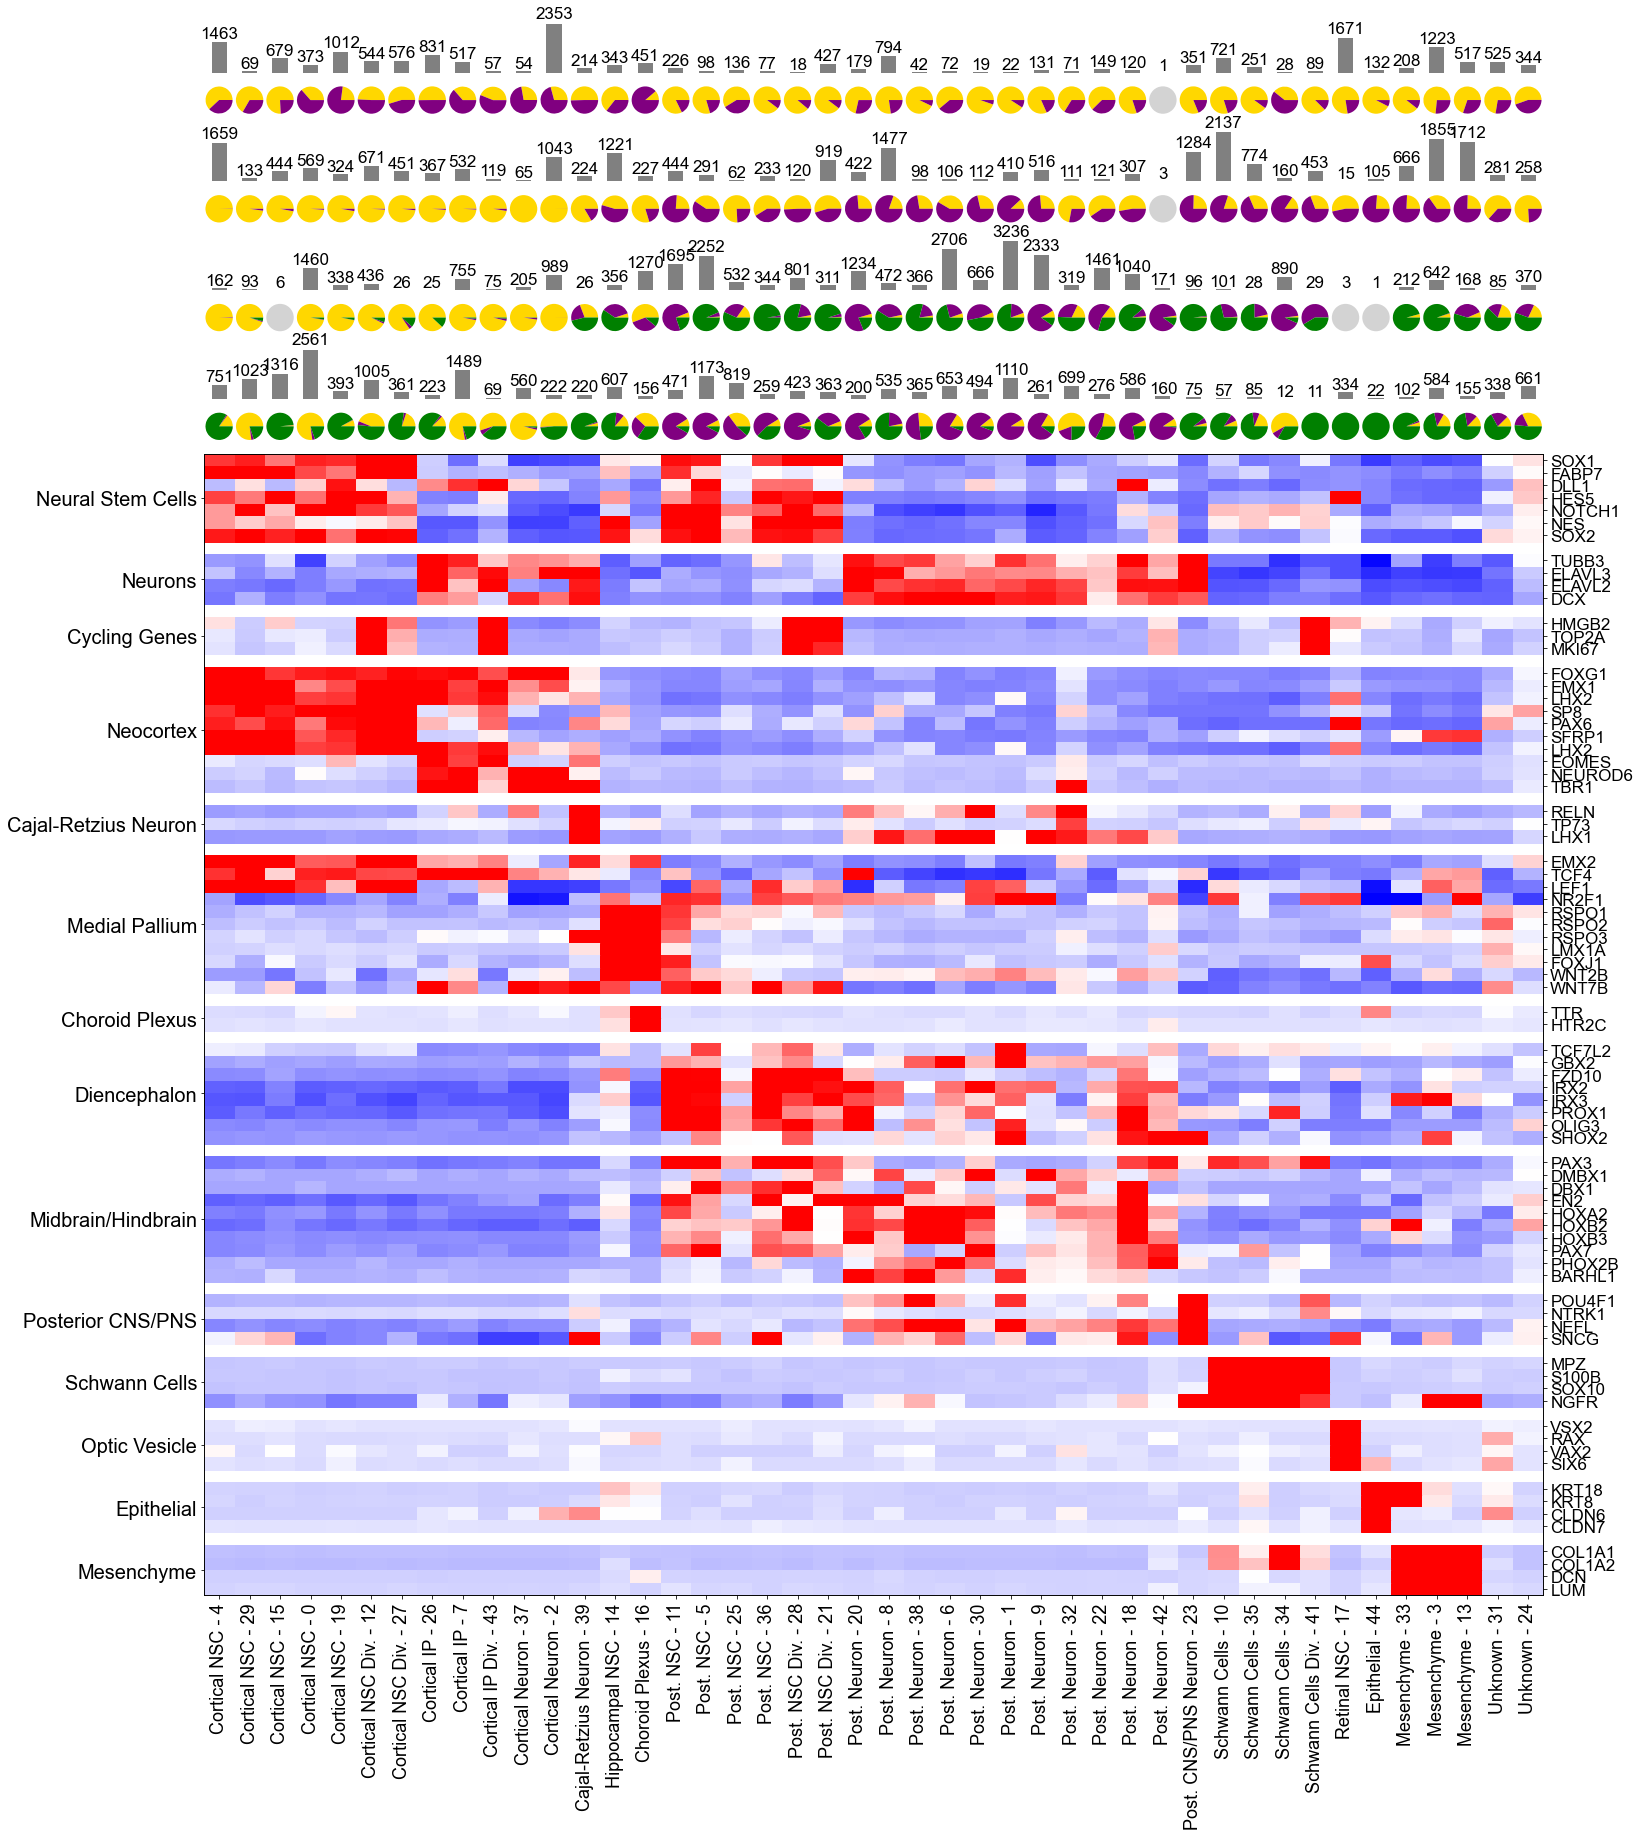

In [81]:
blacklist_genes = []
reg_and_temp_genes = {}
with open('/project/elkabetz_lab_data/sequencing/scrna/d30_organoids/analysis/data/scRNA_regional_and_temporal_genes.txt','r') as reg_and_temp_genes_fn:
    for i,row in enumerate(reg_and_temp_genes_fn):
        spl = row.strip("\r\n").split("\t")
        if i == 0: 
            continue
        if spl[0] in blacklist_genes: continue
        if spl[-1] not in reg_and_temp_genes:
            reg_and_temp_genes[spl[-1]] = []
        reg_and_temp_genes[spl[-1]].append((spl[0],spl[1]))


tmp_reg = copy.deepcopy(reg_and_temp_genes['Brain Regions Genes'])
for gene in ['MKI67','TOP2A','HMGB2']:
    tmp_reg.insert(7,(gene,'Cycling Genes'))

for gene in ['POU4F1', 'NTRK1', 'NEFL', 'SNCG']:
    tmp_reg.insert(-4,(gene,'Posterior CNS/PNS'))

for gene in ['MPZ','S100B','SOX10','NGFR','MAG']:
    tmp_reg.insert(-4,(gene,'Schwann Cells'))

for gene in ['LHX1','TP73','RELN']:
    tmp_reg.insert(19,(gene,'Cajal-Retzius Neuron'))

for gene in ['KRT18', 'KRT8', 'CLDN6', 'CLDN7']:
    tmp_reg.append((gene,'Epithelial'))

for gene in ['COL1A1','COL1A2','DCN','LUM']:
    tmp_reg.append((gene,'Mesenchyme'))

for gene in ['DCX','ELAVL2','ELAVL3','TUBB3']:
    tmp_reg.insert(7,(gene,'Neurons'))

tmp_reg_sub = []
for j,reg in enumerate(tmp_reg):
    if reg[0] in ['ECSCR','MAG','SIX3']: continue
    tmp_reg_sub.append(reg)
    if reg[0] == 'FOXG1':
        tmp_reg_sub.append(('EMX1','Neocortex'))
        tmp_reg_sub.append(('LHX2','Neocortex'))
    if reg[0] == 'WNT7B':
        tmp_reg_sub.append(('TTR','Choroid Plexus'))
        tmp_reg_sub.append(('HTR2C','Choroid Plexus'))


ordered_clusters = sorted(set(adata_merged.obs['louvain']))
ordered_cell_types = ['Cortical NSC',
'Cortical NSC Dividing','Cortical IP','Cortical IP Dividing',
'Cortical Transitory',
'Cortical Neuron','Subpallium Neuron','Cajal-Retzius Neuron',
'Hippocampal NSC','Hippocampal NSC Dividing','Choroid Plexus','Posterior NSC','Posterior NSC Dividing',
'Posterior Neuron','Posterior CNS/PNS Neuron','PNS Dividing','Schwann Cells','Schwann Cells Dividing','Retinal NSC',
'Endothelial','Epithelial','Mesoderm','Mesoderm Dividing','Mesenchyme','Mesenchyme Dividing','Unknown']
ordered_cell_types = [x for x in ordered_cell_types if x in list(adata_merged.obs['cell_type'])]
ordered_clusters = []
for cell_type in ordered_cell_types:
    for clust in cell_type_dict:
        if cell_type_dict[clust] == cell_type:
            ordered_clusters.append(clust)

fig = plt.figure(figsize=(24,30))
breaks=[]
gs = gridspec.GridSpec(30,len(ordered_clusters)+len(breaks),wspace=0.01, hspace=0.01)
y_start,y_end=8,9
ax = plt.subplot(gs[y_end:,:])
fig = make_heatmap_zscore(fig,ax,tmp_reg_sub,adata_merged_no_doublets,ordered_clusters,
                   breaks=breaks,labs = [cell_type_dict[x].replace("Dividing","Div.").replace("Posterior","Post.") + ' - '+str(x) for x in ordered_clusters],xrotation=True,
                         y_fontsize=17,reg_lab_fontsize=20)
fig = add_picharts(fig,2,3,ordered_clusters,adata_merged_no_doublets,line_sub='FOK1',ylab=False)
fig = add_bars(fig,1,2,ordered_clusters,adata_merged_no_doublets,line_sub='FOK1',text_fontsize=17,ylab=False)
fig = add_picharts(fig,4,5,ordered_clusters,adata_merged_no_doublets,line_sub='KUCG2',ylab=False)
fig = add_bars(fig,3,4,ordered_clusters,adata_merged_no_doublets,line_sub='KUCG2',text_fontsize=17,ylab=False)
fig = add_picharts(fig,6,7,ordered_clusters,adata_merged_no_doublets,line_sub='zip8k8',ylab=False)
fig = add_bars(fig,5,6,ordered_clusters,adata_merged_no_doublets,line_sub='zip8k8',text_fontsize=17,ylab=False)
fig = add_picharts(fig,8,9,ordered_clusters,adata_merged_no_doublets,line_sub='zip13k5',ylab=False)
fig = add_bars(fig,7,8,ordered_clusters,adata_merged_no_doublets,line_sub='zip13k5',text_fontsize=17,ylab=False)
plt.tight_layout()
plt.savefig('figures/'+line_+'/heatmap_clusters.png',dpi=500,bbox_inches='tight')
plt.savefig('figures/'+line_+'/heatmap_clusters.pdf',bbox_inches='tight')

... storing 'cell_type' as categorical
... storing 'cell_type_general' as categorical
... storing 'cell_type_clust' as categorical


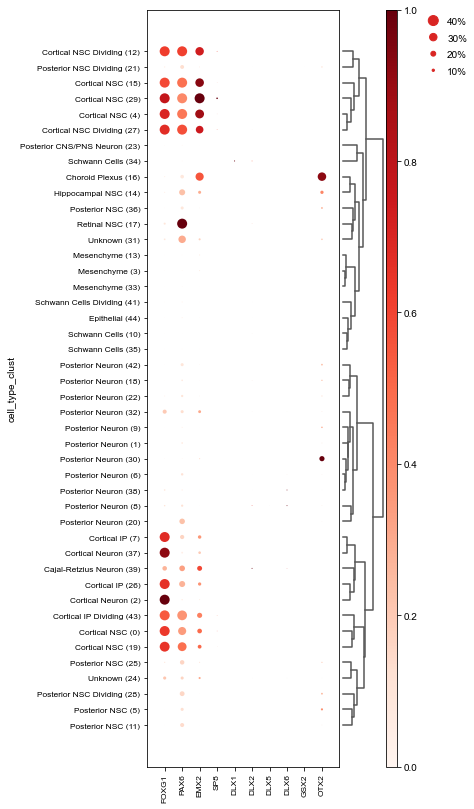

In [36]:
adata_merged_no_doublets.obs['cell_type_clust'] = [x+ ' ('+y+')' for x,y in zip(adata_merged_no_doublets.obs['cell_type'],adata_merged_no_doublets.obs['louvain'])]
sc.pl.dotplot(adata_merged_no_doublets,var_names=['FOXG1','PAX6','EMX2','SP8','DLX1','DLX2','DLX5','DLX6','GSX2','OTX2'],
    groupby='cell_type_clust',dendrogram=True,dot_min=0.01,dot_max=0.4,save=line_+'dotplot.ob_cortical_genes.pdf',standard_scale='var')#,dot_min=0.01,dot_max=0.5


clust_dict_label = {}
for clust,cell_type in zip(adata_merged_no_doublets.obs['louvain'],adata_merged_no_doublets.obs['cell_type']):
    clust_dict_label[clust] = clust+' ('+cell_type+')'

clusts = ordered_clusters
genes = ['FOXG1','PAX6','EMX2','SP8','DLX1','DLX2','DLX5','DLX6','GSX2','OTX2']

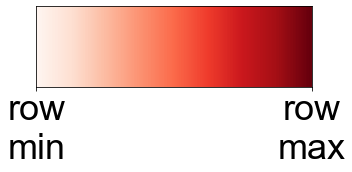

In [37]:
fig = plt.figure(figsize=(5,2.5))
a=np.outer(np.ones(10),np.linspace(0,1,101))
plt.imshow(a,aspect='auto',cmap=cm.Reds)
plt.yticks([])
plt.xticks([plt.xlim()[0],plt.xlim()[1]],['row\nmin','row\nmax'],fontsize=36)
#plt.title('Normalized Expression',fontsize=30)
plt.tight_layout()
plt.savefig('figures/'+line_+'/ob_cortical_genes.colorbar.png',dpi=500)

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


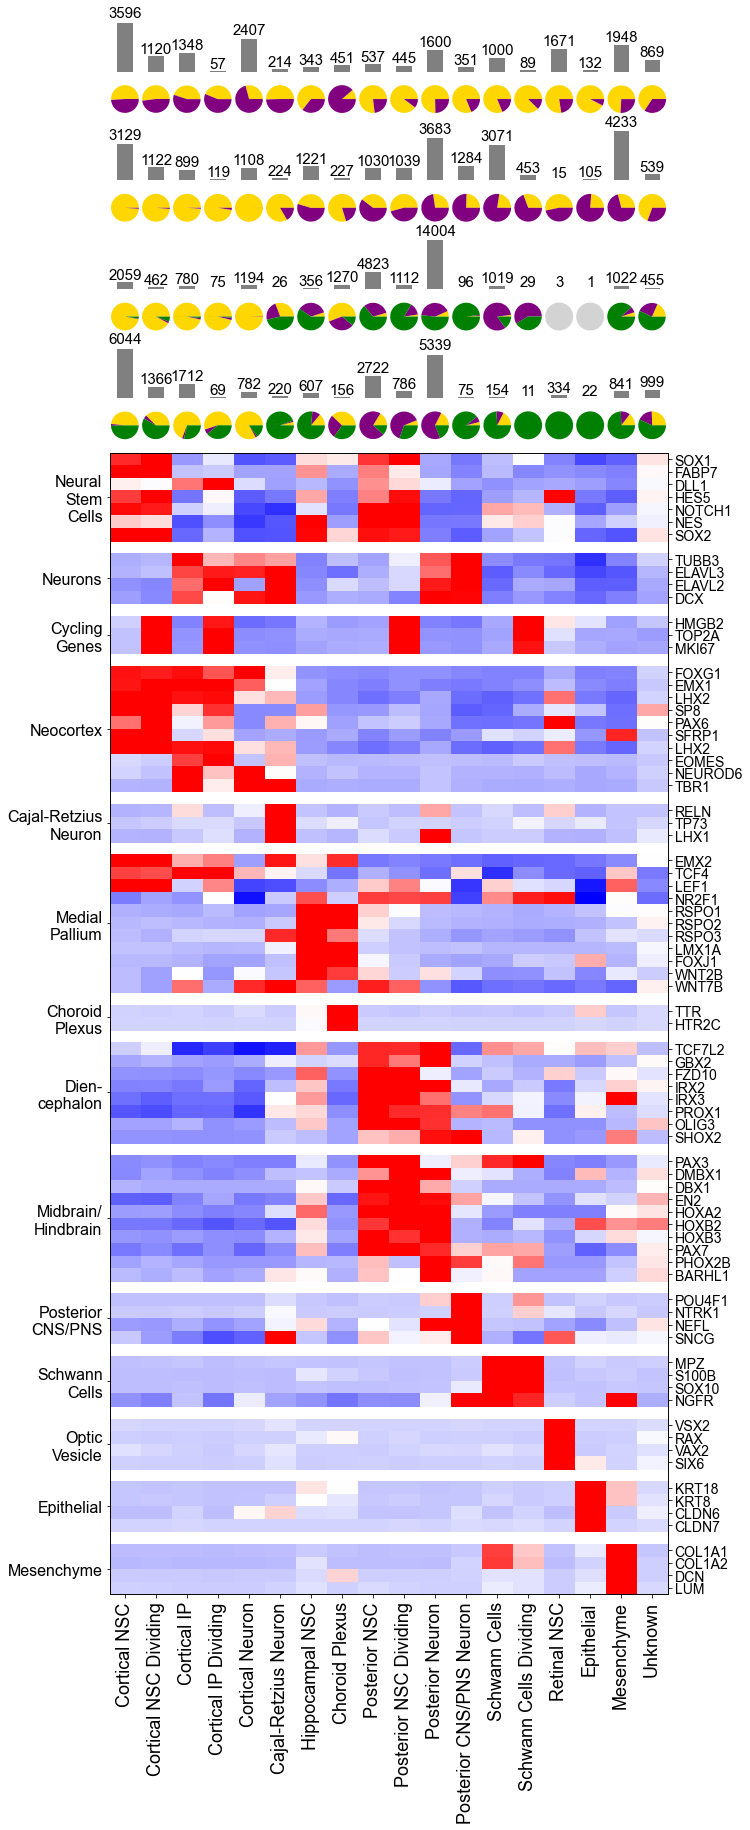

In [46]:
cell_types_tot = set(adata_merged.obs['cell_type'])
ordered_cell_types_sub = [x for x in ordered_cell_types if x in cell_types_tot]
'''
fig = plt.figure(figsize=(12,24))
breaks=[]
gs = gridspec.GridSpec(20,len(ordered_cell_types_sub)+len(breaks),wspace=0.01, hspace=0.01)
y_start,y_end=4,5
ax = plt.subplot(gs[y_end:,:])
fig = make_heatmap_zscore(fig,ax,tmp_reg_sub,adata_merged,ordered_cell_types_sub,
                   breaks=breaks,labs = [str(x) for x in ordered_cell_types_sub],groupby='cell_type',
                   xrotation=True)
fig = add_picharts(fig,1,2,ordered_cell_types_sub,adata_merged,groupby='cell_type',line_sub='FOK1')
fig = add_picharts(fig,2,3,ordered_cell_types_sub,adata_merged,groupby='cell_type',line_sub='KUCG2')
fig = add_picharts(fig,3,4,ordered_cell_types_sub,adata_merged,groupby='cell_type',line_sub='zip8k8')
fig = add_picharts(fig,4,5,ordered_cell_types_sub,adata_merged,groupby='cell_type',line_sub='zip13k5')
plt.tight_layout()
plt.savefig('figures/'+line_+'/heatmap_cell_types.no_bars.png',dpi=500,bbox_inches='tight')
plt.savefig('figures/'+line_+'/heatmap_cell_types.no_bars.pdf',bbox_inches='tight')
'''

cell_types_tot = set(adata_merged_no_doublets.obs['cell_type'])
ordered_cell_types_sub = [x for x in ordered_cell_types if x in cell_types_tot]
fig = plt.figure(figsize=(10,30))
breaks=[]
gs = gridspec.GridSpec(30,len(ordered_cell_types_sub)+len(breaks),wspace=0.01, hspace=0.01)
y_start,y_end=8,9
ax = plt.subplot(gs[y_end:,:])
fig = make_heatmap_zscore(fig,ax,[(x[0],x[1].replace(" ","\n").replace("n/","n/\n").replace("Dien","Dien-\n")) for x in tmp_reg_sub],
                          adata_merged_no_doublets,ordered_cell_types_sub,
                   breaks=breaks,labs = [str(x) for x in ordered_cell_types_sub],groupby='cell_type',
                   xrotation=True,y_fontsize=14)
fig = add_picharts(fig,2,3,ordered_cell_types_sub,adata_merged_no_doublets,groupby='cell_type',line_sub='FOK1',ylab=False)
fig = add_bars(fig,1,2,ordered_cell_types_sub,adata_merged_no_doublets,groupby='cell_type',line_sub='FOK1',text_fontsize=15,ylab=False)
fig = add_picharts(fig,4,5,ordered_cell_types_sub,adata_merged_no_doublets,groupby='cell_type',line_sub='KUCG2',ylab=False)
fig = add_bars(fig,3,4,ordered_cell_types_sub,adata_merged_no_doublets,groupby='cell_type',line_sub='KUCG2',text_fontsize=15,ylab=False)
fig = add_picharts(fig,6,7,ordered_cell_types_sub,adata_merged_no_doublets,groupby='cell_type',line_sub='zip8k8',ylab=False)
fig = add_bars(fig,5,6,ordered_cell_types_sub,adata_merged_no_doublets,groupby='cell_type',line_sub='zip8k8',text_fontsize=15,ylab=False)
fig = add_picharts(fig,8,9,ordered_cell_types_sub,adata_merged_no_doublets,groupby='cell_type',line_sub='zip13k5',ylab=False)
fig = add_bars(fig,7,8,ordered_cell_types_sub,adata_merged_no_doublets,groupby='cell_type',line_sub='zip13k5',text_fontsize=15,ylab=False)
plt.tight_layout()
plt.savefig('figures/'+line_+'/heatmap_cell_types.png',dpi=250,bbox_inches='tight')
plt.savefig('figures/'+line_+'/heatmap_cell_types.pdf',bbox_inches='tight')


In [44]:
[(x[0],x[1].replace(" ","\n").replace("n/","n/\n")) for x in tmp_reg_sub]

[('SOX1', 'Neural\nStem\nCells'),
 ('FABP7', 'Neural\nStem\nCells'),
 ('DLL1', 'Neural\nStem\nCells'),
 ('HES5', 'Neural\nStem\nCells'),
 ('NOTCH1', 'Neural\nStem\nCells'),
 ('NES', 'Neural\nStem\nCells'),
 ('SOX2', 'Neural\nStem\nCells'),
 ('TUBB3', 'Neurons'),
 ('ELAVL3', 'Neurons'),
 ('ELAVL2', 'Neurons'),
 ('DCX', 'Neurons'),
 ('HMGB2', 'Cycling\nGenes'),
 ('TOP2A', 'Cycling\nGenes'),
 ('MKI67', 'Cycling\nGenes'),
 ('FOXG1', 'Neocortex'),
 ('EMX1', 'Neocortex'),
 ('LHX2', 'Neocortex'),
 ('SP8', 'Neocortex'),
 ('PAX6', 'Neocortex'),
 ('SFRP1', 'Neocortex'),
 ('LHX2', 'Neocortex'),
 ('EOMES', 'Neocortex'),
 ('NEUROD6', 'Neocortex'),
 ('TBR1', 'Neocortex'),
 ('RELN', 'Cajal-Retzius\nNeuron'),
 ('TP73', 'Cajal-Retzius\nNeuron'),
 ('LHX1', 'Cajal-Retzius\nNeuron'),
 ('EMX2', 'Medial\nPallium'),
 ('TCF4', 'Medial\nPallium'),
 ('LEF1', 'Medial\nPallium'),
 ('NR2F1', 'Medial\nPallium'),
 ('RSPO1', 'Medial\nPallium'),
 ('RSPO2', 'Medial\nPallium'),
 ('RSPO3', 'Medial\nPallium'),
 ('LMX1A', 

Trying to set attribute `.obs` of view, copying.
/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


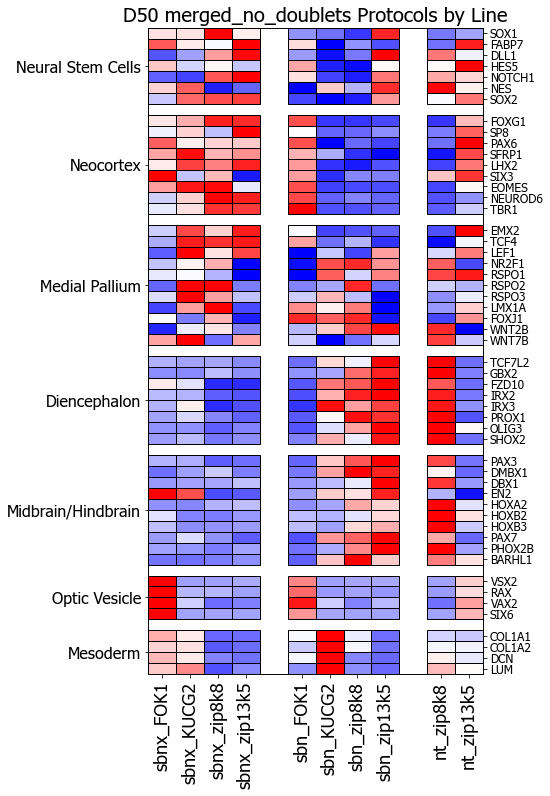

In [40]:
adata_merged_no_doublets = adata_merged[adata_merged.obs['cell_type']!='doublet']
adata_merged_no_doublets.obs['tx_line'] = [x+'_'+y for x,y in zip(adata_merged_no_doublets.obs['tx'],adata_merged_no_doublets.obs['line'])]
adata_merged.obs['tx_line'] = [x+'_'+y for x,y in zip(adata_merged.obs['tx'],adata_merged.obs['line'])]
ordered_tx_line = ['sbnx_FOK1', 'sbnx_KUCG2', 'sbnx_zip8k8', 'sbnx_zip13k5', 'sbn_FOK1', 'sbn_KUCG2', 'sbn_zip8k8', 'sbn_zip13k5', 'nt_zip8k8', 'nt_zip13k5']

adata_merged_no_doublets.obs['index'] = range(len(adata_merged_no_doublets.obs))

tmp_reg_line = copy.deepcopy(reg_and_temp_genes['Brain Regions Genes'])
for gene in ['COL1A1','COL1A2','DCN','LUM']:
    tmp_reg_line.append((gene,'Mesoderm'))

fig = plt.figure(figsize=(6,14))
breaks=[3,7]
gs = gridspec.GridSpec(20,len(ordered_tx_line)+len(breaks),wspace=0.05, hspace=0.05)
y_start,y_end=2,3
ax = plt.subplot(gs[y_end:,:])
fig = make_heatmap_zscore(fig,ax,tmp_reg_line,adata_merged_no_doublets,ordered_tx_line,
                   breaks=breaks,labs = [str(x) for x in ordered_tx_line],groupby='tx_line',xrotation=True,edgecolor='black')
plt.title('D50 '+line_+' Protocols by Line',fontsize=20)
plt.tight_layout()
plt.savefig('figures/'+line_+'/heatmap_lines.png',dpi=250,bbox_inches='tight')

In [43]:
ordered_cell_types.append('doublet')
cell_type_class_dict = {}
for cell_type in ordered_cell_types:
    if 'Cortical' in cell_type: cell_type_class_dict[cell_type]='Cortical'
    elif 'PNS' in cell_type or 'Posterior' in cell_type or 'Schwann' in cell_type: cell_type_class_dict[cell_type]='Posterior'
    elif 'Hippocampal' in cell_type or 'Choroid' in cell_type or 'Cajal' in cell_type: cell_type_class_dict[cell_type]='Medial Pallium'
    elif 'Retinal' in cell_type in cell_type: cell_type_class_dict[cell_type]='Retinal'
    elif 'Unknown' in cell_type in cell_type: cell_type_class_dict[cell_type]='Unknown'
    elif cell_type !='doublet': cell_type_class_dict[cell_type]='Non-neural'
    else: cell_type_class_dict['doublet']='doublet'

adata_merged.obs['cell_type_class'] = [cell_type_class_dict[x] for x in adata_merged.obs['cell_type']]

In [45]:
adata_merged.obs['cell_type_clust'] = [x+ ' ('+y+')' for x,y in zip(adata_merged.obs['cell_type'],adata_merged.obs['louvain'])]
adata_merged.obs['protocol'] = [tx_dict[x] for x in adata_merged.obs['tx']]

output = open('data/cell_identity.removed_doublets.tsv','w')
header = list(adata_merged.obs.columns)
output.write('cell_id\t'+'\t'.join(header)+'\n')
for row in adata_merged.obs.itertuples():
    output.write('\t'.join([str(x) for x in list(row)])+'\n')

output.close()

In [47]:
adata_merged_no_doublets.obs['cell_type_clust'] = [x+ ' ('+y+')' for x,y in zip(adata_merged_no_doublets.obs['cell_type'],adata_merged_no_doublets.obs['louvain'])]
adata_merged_no_doublets.obs['protocol'] = [tx_dict[x] for x in adata_merged_no_doublets.obs['tx']]

... storing 'cell_type_clust' as categorical
... storing 'protocol' as categorical


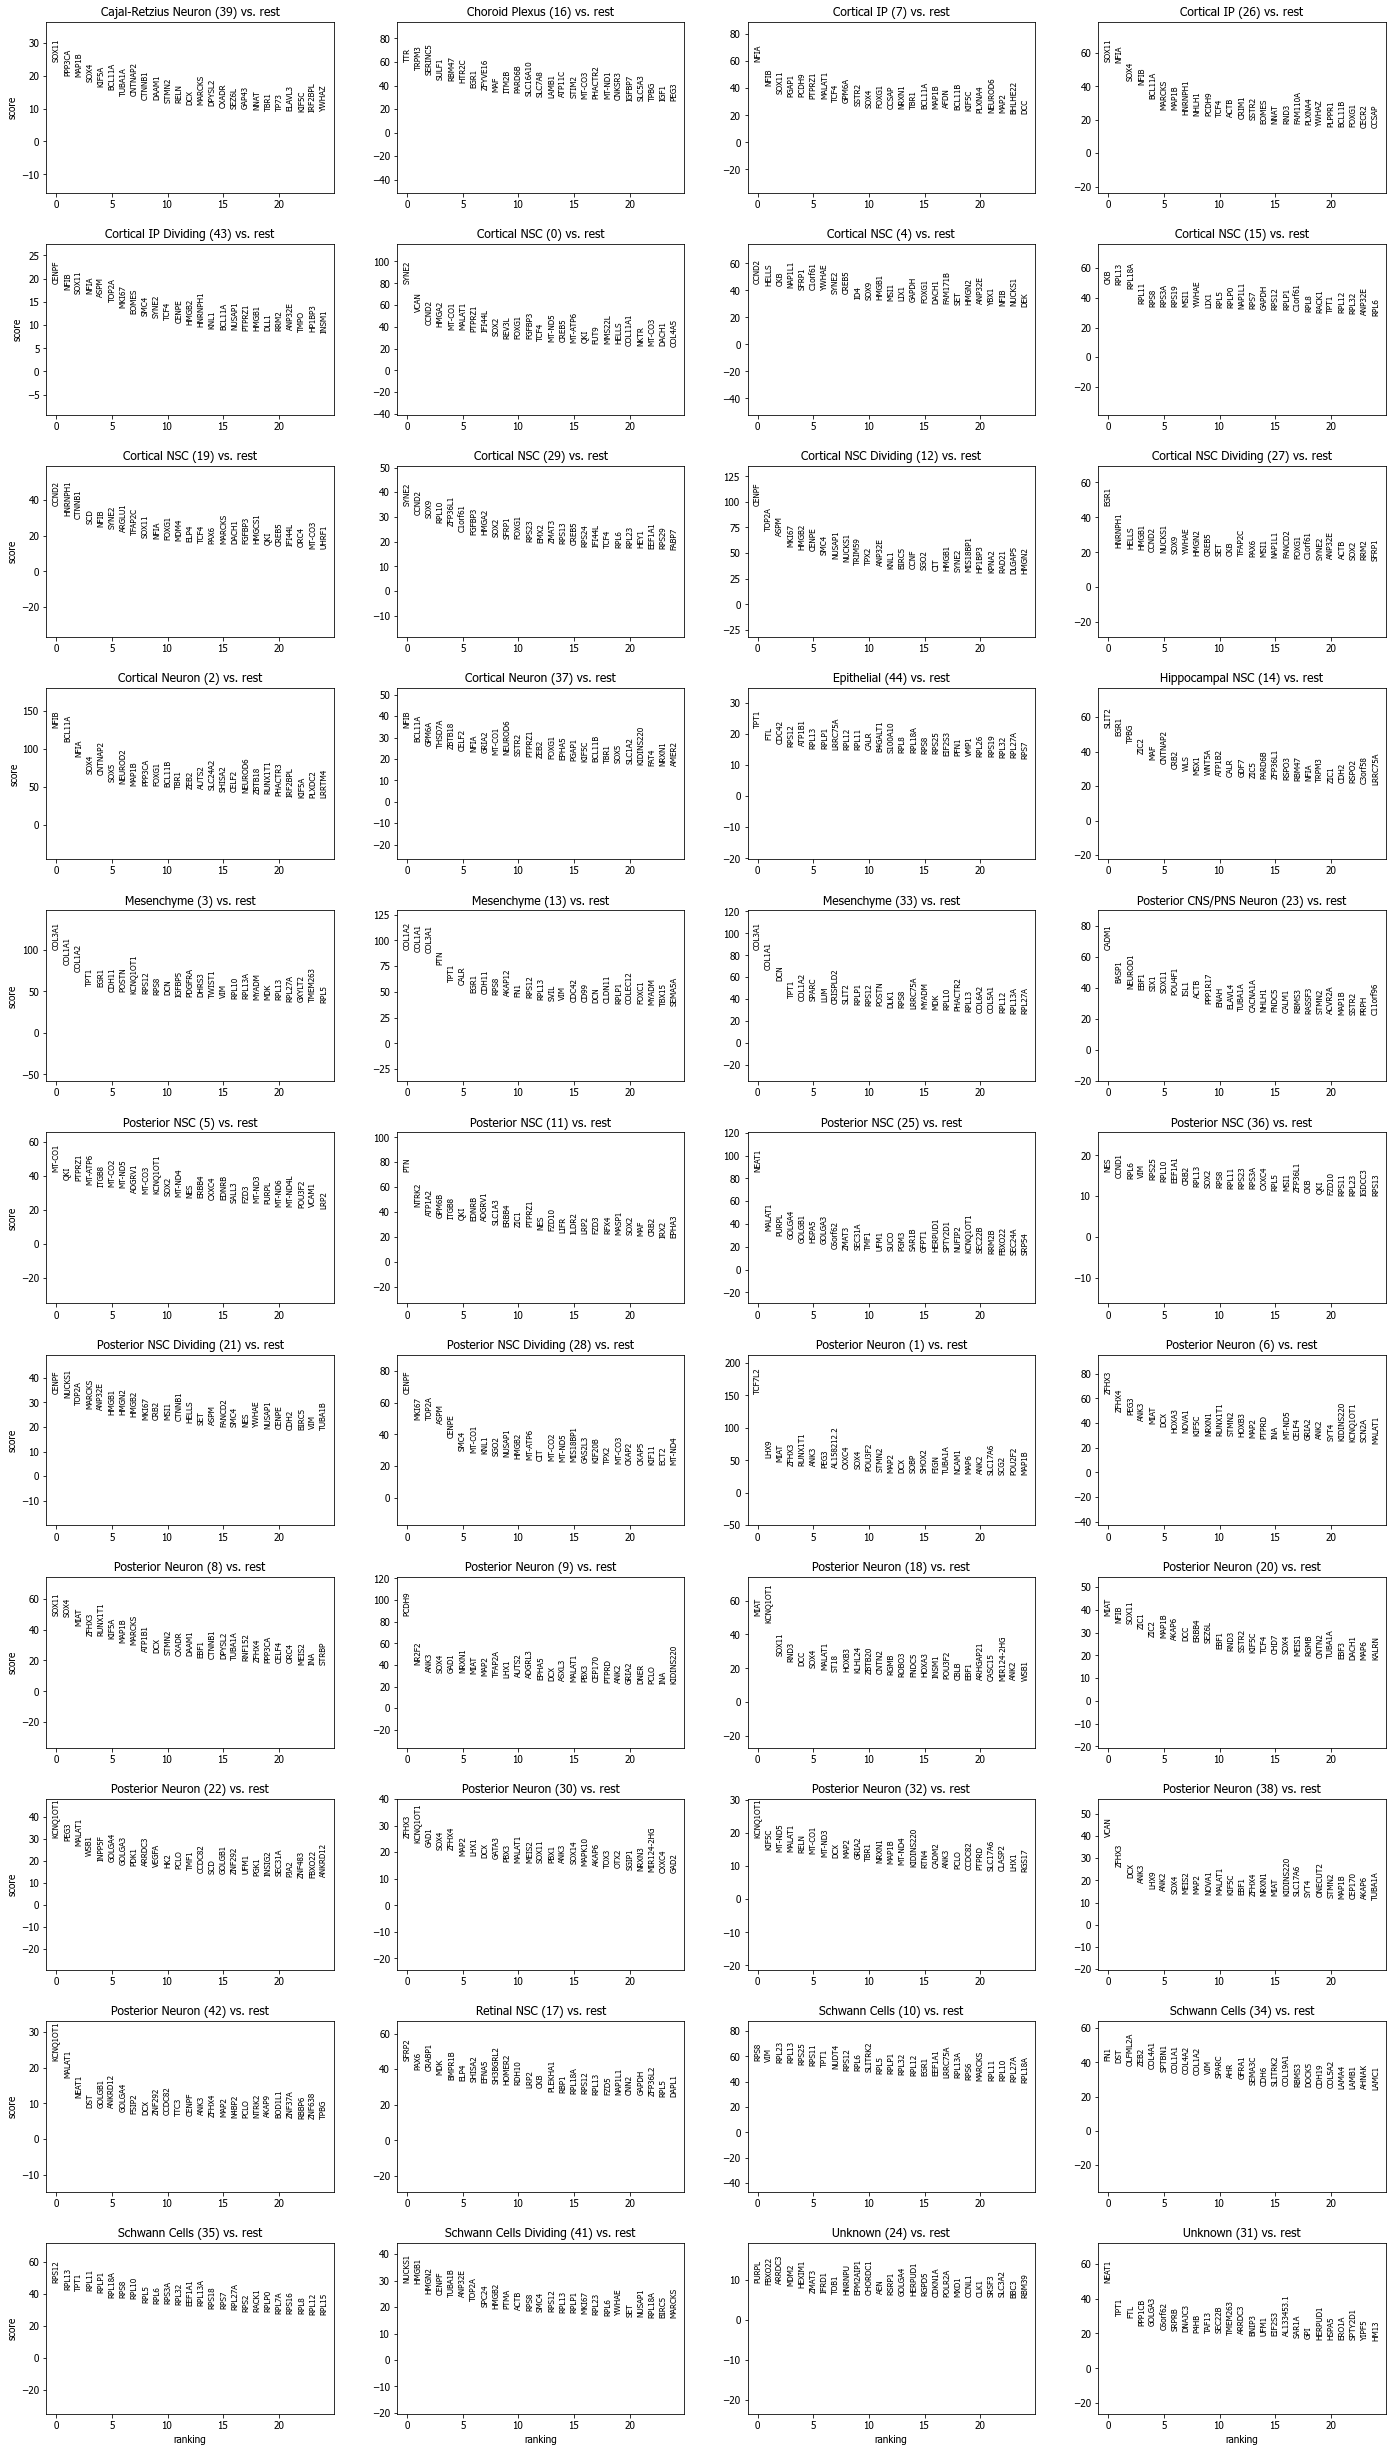

Cajal-Retzius Neuron (39)
Choroid Plexus (16)
Cortical IP (26)
Cortical IP (7)
Cortical IP Dividing (43)
Cortical NSC (0)
Cortical NSC (15)
Cortical NSC (19)
Cortical NSC (29)
Cortical NSC (4)
Cortical NSC Dividing (12)
Cortical NSC Dividing (27)
Cortical Neuron (2)
Cortical Neuron (37)
Epithelial (44)
Hippocampal NSC (14)
Mesenchyme (13)
Mesenchyme (3)
Mesenchyme (33)
Posterior CNS/PNS Neuron (23)
Posterior NSC (11)
Posterior NSC (25)
Posterior NSC (36)
Posterior NSC (5)
Posterior NSC Dividing (21)
Posterior NSC Dividing (28)
Posterior Neuron (1)
Posterior Neuron (18)
Posterior Neuron (20)
Posterior Neuron (22)
Posterior Neuron (30)
Posterior Neuron (32)
Posterior Neuron (38)
Posterior Neuron (42)
Posterior Neuron (6)
Posterior Neuron (8)
Posterior Neuron (9)
Retinal NSC (17)
Schwann Cells (10)
Schwann Cells (34)
Schwann Cells (35)
Schwann Cells Dividing (41)
Unknown (24)
Unknown (31)
Cajal-Retzius Neuron (39)
Choroid Plexus (16)
Cortical IP (26)
Cortical IP (7)
Cortical IP Dividing (

In [48]:
sc.tl.rank_genes_groups(adata_merged_no_doublets, 'cell_type_clust', method='t-test_overestim_var', n_genes=40000)
sc.pl.rank_genes_groups(adata_merged_no_doublets, n_genes=25, sharey=False)

log_fc_cutoff = 1
pval_cutoff = 0.05
cluster = adata_merged_no_doublets.obs['cell_type_clust'][0]
genes = adata_merged_no_doublets.uns['rank_genes_groups']['names'][cluster]
genes_idx_dict = {}
for j,gene in enumerate(adata_merged_no_doublets.var.index): 
    genes_idx_dict[gene] = j

sig_genes = set([])
adata_merged_no_doublets.obs['Index'] = range(len(adata_merged_no_doublets.obs))
bin_arr = adata_merged_no_doublets.X > 0
for clust in [str(y) for y in sorted([x for x in set(adata_merged_no_doublets.obs['cell_type_clust'])])]:
    print(clust)
    genes_ = adata_merged_no_doublets.uns['rank_genes_groups']['names'][clust]
    sum1 = np.sum(bin_arr[np.array(adata_merged_no_doublets.obs[adata_merged_no_doublets.obs['cell_type_clust'] == clust]['Index']),:],axis=0)
    sum2 = np.sum(bin_arr[np.array(adata_merged_no_doublets.obs[adata_merged_no_doublets.obs['cell_type_clust'] != clust]['Index']),:],axis=0)
    n_cells1 = float(len(adata_merged_no_doublets.obs[adata_merged_no_doublets.obs['cell_type_clust'] == clust]))
    n_cells2 = float(len(adata_merged_no_doublets.obs[adata_merged_no_doublets.obs['cell_type_clust'] != clust]))
    for j,gene in enumerate(genes_):
        logfc = adata_merged_no_doublets.uns['rank_genes_groups']['logfoldchanges'][clust][j]
        pval_adj = adata_merged_no_doublets.uns['rank_genes_groups']['pvals_adj'][clust][j]
        pct1 = sum1[genes_idx_dict[gene]]/n_cells1
        pct2 = sum2[genes_idx_dict[gene]]/n_cells2
        pct_diff = pct1 - pct2
        sig_ = 'FALSE'
        if pval_adj < pval_cutoff and logfc > log_fc_cutoff: sig_genes.add(gene)


adata_merged_no_doublets.obs['Index'] = range(len(adata_merged_no_doublets.obs))
bin_arr = adata_merged_no_doublets.X > 0
output=open('data/'+line_+'.diff_exp.tsv','w')
output.write('gene\tcluster\tcell_type\tcluster_cell_type\tlogfoldchange\tpct.1\tpct.2\tpval_adj\tsignficiant\n')
for clust in [str(y) for y in sorted([x for x in set(adata_merged_no_doublets.obs['cell_type_clust'])])]:
    print(clust)
    genes_ = adata_merged_no_doublets.uns['rank_genes_groups']['names'][clust]
    sum1 = np.sum(bin_arr[np.array(adata_merged_no_doublets.obs[adata_merged_no_doublets.obs['cell_type_clust'] == clust]['Index']),:],axis=0)
    sum2 = np.sum(bin_arr[np.array(adata_merged_no_doublets.obs[adata_merged_no_doublets.obs['cell_type_clust'] != clust]['Index']),:],axis=0)
    n_cells1 = float(len(adata_merged_no_doublets.obs[adata_merged_no_doublets.obs['cell_type_clust'] == clust]))
    n_cells2 = float(len(adata_merged_no_doublets.obs[adata_merged_no_doublets.obs['cell_type_clust'] != clust]))
    for j,gene in enumerate(genes_):
        if gene not in sig_genes:continue
        logfc = adata_merged_no_doublets.uns['rank_genes_groups']['logfoldchanges'][clust][j]
        pval_adj = adata_merged_no_doublets.uns['rank_genes_groups']['pvals_adj'][clust][j]
        pct1 = sum1[genes_idx_dict[gene]]/n_cells1
        pct2 = sum2[genes_idx_dict[gene]]/n_cells2
        pct_diff = pct1 - pct2
        sig_ = 'FALSE'
        if pval_adj < pval_cutoff and logfc > log_fc_cutoff: sig_= 'TRUE'
        output.write(gene+'\t'+str(clust.split("(")[1][:-1])+'\t'+str(clust.split("(")[0][:-1])+'\t'+
            clust+'\t'+str(logfc)+'\t'+
            str(pct1) + '\t' + str(pct2) + '\t' + str(pval_adj)+'\t'+sig_+'\n')

output.close()

In [53]:
cluster = adata_merged_no_doublets.obs['cell_type_clust'][0]
genes = adata_merged_no_doublets.uns['rank_genes_groups']['names'][cluster]
genes_idx_dict = {}
for j,gene in enumerate(adata_merged_no_doublets.var.index): 
    genes_idx_dict[gene] = j

adata_merged_no_doublets.obs['Index'] = range(len(adata_merged_no_doublets.obs))
bin_arr = adata_merged_no_doublets.X > 0
output=open('data/'+line_+'.cluster_markers.tsv','w')
output.write('gene\tcluster\tcell_type\tlogfoldchange\tpct.1\tpct.2\tpval_adj\n')
for clust in [str(y) for y in sorted([x for x in set(adata_merged_no_doublets.obs['cell_type_clust'])])]:
    print(clust)
    genes_ = adata_merged_no_doublets.uns['rank_genes_groups']['names'][clust]
    sum1 = np.sum(bin_arr[np.array(adata_merged_no_doublets.obs[adata_merged_no_doublets.obs['cell_type_clust'] == clust]['Index']),:],axis=0)
    sum2 = np.sum(bin_arr[np.array(adata_merged_no_doublets.obs[adata_merged_no_doublets.obs['cell_type_clust'] != clust]['Index']),:],axis=0)
    n_cells1 = float(len(adata_merged_no_doublets.obs[adata_merged_no_doublets.obs['cell_type_clust'] == clust]))
    n_cells2 = float(len(adata_merged_no_doublets.obs[adata_merged_no_doublets.obs['cell_type_clust'] != clust]))
    for j,gene in enumerate(genes_):
        logfc = adata_merged_no_doublets.uns['rank_genes_groups']['logfoldchanges'][clust][j]
        pval_adj = adata_merged_no_doublets.uns['rank_genes_groups']['pvals_adj'][clust][j]
        pct1 = sum1[genes_idx_dict[gene]]/n_cells1
        pct2 = sum2[genes_idx_dict[gene]]/n_cells2
        pct_diff = pct1 - pct2
        if pval_adj < pval_cutoff and logfc > log_fc_cutoff:
            output.write(gene+'\t'+str(clust.split("(")[1][:-1])+'\t'+str(clust.split("(")[0][:-1])+'\t'+
                clust+'\t'+str(logfc)+'\t'+str(pct1) + '\t' + str(pct2) + '\t' + str(pval_adj)+'\t'+sig_+'\n')

output.close()

Cajal-Retzius Neuron (39)
Choroid Plexus (16)
Cortical IP (26)
Cortical IP (7)
Cortical IP Dividing (43)
Cortical NSC (0)
Cortical NSC (15)
Cortical NSC (19)
Cortical NSC (29)
Cortical NSC (4)
Cortical NSC Dividing (12)
Cortical NSC Dividing (27)
Cortical Neuron (2)
Cortical Neuron (37)
Epithelial (44)
Hippocampal NSC (14)
Mesenchyme (13)
Mesenchyme (3)
Mesenchyme (33)
Posterior CNS/PNS Neuron (23)
Posterior NSC (11)
Posterior NSC (25)
Posterior NSC (36)
Posterior NSC (5)
Posterior NSC Dividing (21)
Posterior NSC Dividing (28)
Posterior Neuron (1)
Posterior Neuron (18)
Posterior Neuron (20)
Posterior Neuron (22)
Posterior Neuron (30)
Posterior Neuron (32)
Posterior Neuron (38)
Posterior Neuron (42)
Posterior Neuron (6)
Posterior Neuron (8)
Posterior Neuron (9)
Retinal NSC (17)
Schwann Cells (10)
Schwann Cells (34)
Schwann Cells (35)
Schwann Cells Dividing (41)
Unknown (24)
Unknown (31)


In [54]:
for clust in [str(y) for y in sorted([x for x in set(adata_merged.obs['louvain'])])]:
    print(clust,np.mean(adata_merged.obs[adata_merged.obs['louvain']==clust]['doublet_score']))

0 0.0548129623604765
1 0.07110396345892053
10 0.055733626440741556
11 0.05708797441449752
12 0.0572837318340717
13 0.058324098159476645
14 0.07488425213813633
15 0.05749545843753256
16 0.07095892790713539
17 0.058897708911664785
18 0.06876632776512015
19 0.06311787947729602
2 0.05521725008321824
20 0.05899468892176548
21 0.06850874033419715
22 0.07464066049373626
23 0.06306995947853486
24 0.07228307496396971
25 0.0554936921196457
26 0.06263295803066948
27 0.06354153043056096
28 0.06759882158210052
29 0.0726707810888092
3 0.07509838001831334
30 0.06245472809925518
31 0.06522226771446653
32 0.07973429334719594
33 0.0636707468007135
34 0.06716252771070853
35 0.05929784911961815
36 0.07321804023678459
37 0.06282713825300003
38 0.07347810478003473
39 0.08264877593994069
4 0.05892310249029908
40 0.19553963232072086
41 0.07896501349207072
42 0.10654590458586949
43 0.1035481124418997
44 0.08066958319240844
5 0.06422817366692717
6 0.0737526584769743
7 0.06888123549217132
8 0.05871845654491998
9

In [55]:
output = open('data/'+line_+'.clust_profiles.tsv','w')
output.write('cluster\tcell_type\tcell_type_class\t'+'\t'.join(list(adata_merged.var.index))+'\n')
adata_merged_no_doublets.obs['index'] = range(len(adata_merged_no_doublets.obs))
for clust in set(adata_merged_no_doublets.obs['louvain']):
    output.write(str(clust)+'\t'+cell_type_dict[str(clust)]+'\t'+cell_type_class_dict[cell_type_dict[str(clust)]]+'\t')
    output.write('\t'.join([str(x) for x in adata_merged_no_doublets.X[adata_merged_no_doublets.obs['louvain']==clust,:].mean(axis=0)]))
    output.write('\n')

output.close()